# Comparative Analysis of Collaborative Filtering Algorithms on MovieLens 100K Dataset


Candidate Number: 24155. 24588

In [2]:
# !cd
# !rm -rf .local
# !ln -s /storage/config/.local/

In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/z/.netrc


True

In [ ]:
! wandb login

In [5]:
from torch.utils.data import Dataset, DataLoader
import torchmetrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns
from IPython.display import Image, display
from statsmodels.distributions.empirical_distribution import ECDF
import torch
from pathlib import Path
from wordcloud import WordCloud
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Download Data

We use MovieLens-100k

In [6]:
# ! wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
# ! unzip ml-latest-small.zip


# MovieLens Dataset Documentation
## Overview
This dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100836 ratings and 3683 tag applications across 9742 movies. These data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files links.csv, movies.csv, ratings.csv and tags.csv. More details about the contents and use of all these files follows.
### User Ids

- MovieLens users were selected at random for inclusion.
- Their ids have been anonymized.
- User ids are consistent between `ratings.csv` and `tags.csv` (i.e., the same id refers to the same user across the two files).

### Movie Ids

- Only movies with at least one rating or tag are included in the dataset.
- These movie ids are consistent with those used on the MovieLens web site (e.g., id 1 corresponds to the URL <https://movielens.org/movies/1>).
- Movie ids are consistent between `ratings.csv`, `tags.csv`, `movies.csv`, and `links.csv` (i.e., the same id refers to the same movie across these four data files).

### Files and Their Structures

#### Ratings Data File Structure (`ratings.csv`)

- Contains all user movie ratings.
- **Format**: `userId,movieId,rating,timestamp`
- **Order**: First by `userId`, then by `movieId`.
- **Ratings**: On a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).
- **Timestamps**: Represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

#### Tags Data File Structure (`tags.csv`)

- Contains all user-generated tags for movies.
- **Format**: `userId,movieId,tag,timestamp`
- **Order**: First by `userId`, then by `movieId`.
- **Tags**: Typically a single word or short phrase, with meaning determined by the user.
- **Timestamps**: Represent seconds since midnight UTC of January 1, 1970.

#### Movies Data File Structure (`movies.csv`)

- Contains information on movies.
- **Format**: `movieId,title,genres`
- **Title**: Includes the year of release in parentheses. May contain errors or inconsistencies.
- **Genres**: A pipe-separated list, from a predefined set including Action, Comedy, Drama, etc., or "(no genres listed)".

#### Links Data File Structure (`links.csv`)

- Contains identifiers linking to other movie data sources.
- **Format**: `movieId,imdbId,tmdbId`
- **movieId**: Identifier used by <https://movielens.org>.
- **imdbId**: Identifier for movies used by <http://www.imdb.com>.
- **tmdbId**: Identifier for movies used by <https://www.themoviedb.org>.



## Load Data

In [7]:
dataset_path = Path('ml-latest-small')
tags = pd.read_csv(
    dataset_path/"tags.csv",
    sep=",",
)
ratings = pd.read_csv(
    dataset_path/"ratings.csv",
    sep=",",
)

movies = pd.read_csv(
    dataset_path/"movies.csv",
    sep=","
)
links = pd.read_csv(
    dataset_path/"links.csv",
    sep=","
)

In [8]:
links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


In [9]:
tags

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [10]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [11]:
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


# Exploratory Data Analysis

In [12]:
movie_ratings = ratings.groupby('movieId').size().reset_index(name='num_ratings')
movie_ratings_merged = pd.merge(movie_ratings, movies, on='movieId')


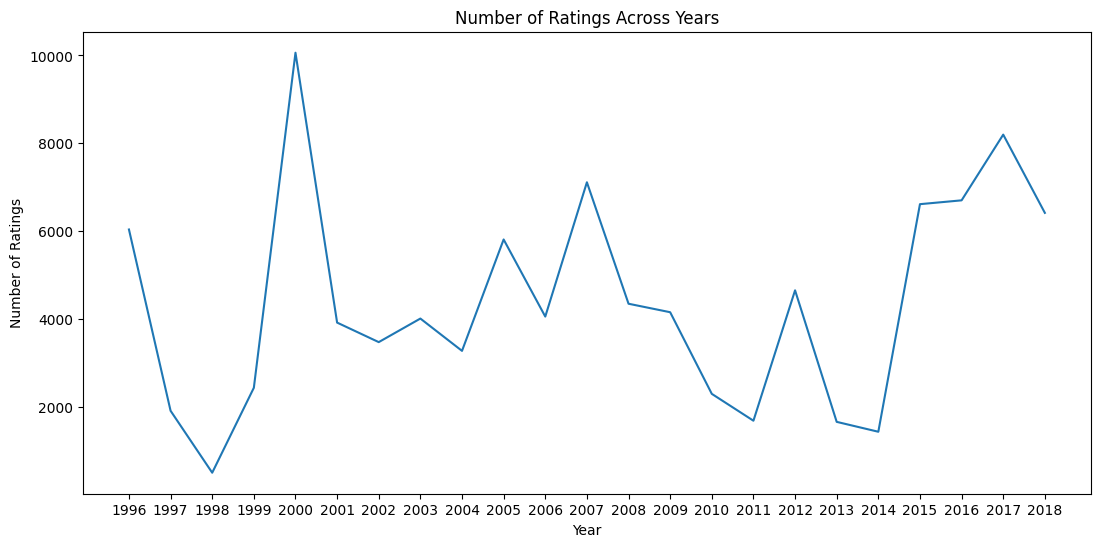

The year with the most ratings is: 2000


In [13]:
ratings_copy = ratings.copy()

# Convert timestamp to datetime
ratings_copy['timestamp'] = pd.to_datetime(ratings_copy['timestamp'], unit='s')

# Extract the year from the timestamp
ratings_copy['year'] = ratings_copy['timestamp'].dt.year

# Group by year and count the number of ratings
ratings_per_year = ratings_copy.groupby('year')['rating'].count()

# Plot the density of ratings across years
plt.figure(figsize=(13, 6))
plt.plot(ratings_per_year.index, ratings_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings Across Years')
plt.xticks(range(ratings_per_year.index.min(), ratings_per_year.index.max() + 1))
plt.savefig('ratings_density.png')
plt.show()

# Find the year with the most ratings
year_most_ratings = ratings_per_year.idxmax()
print(f"The year with the most ratings is: {year_most_ratings}")

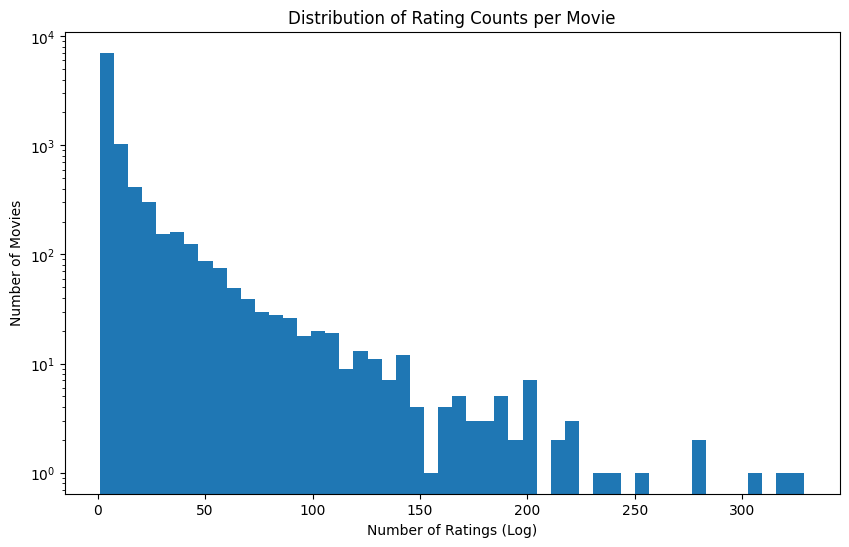

In [14]:
plt.figure(figsize=(10,6))
plt.hist(movie_ratings['num_ratings'], bins=50, log = True)
plt.xlabel('Number of Ratings (Log)')
plt.ylabel('Number of Movies')
plt.title('Distribution of Rating Counts per Movie')
plt.savefig('rating_counts.png')
plt.show()

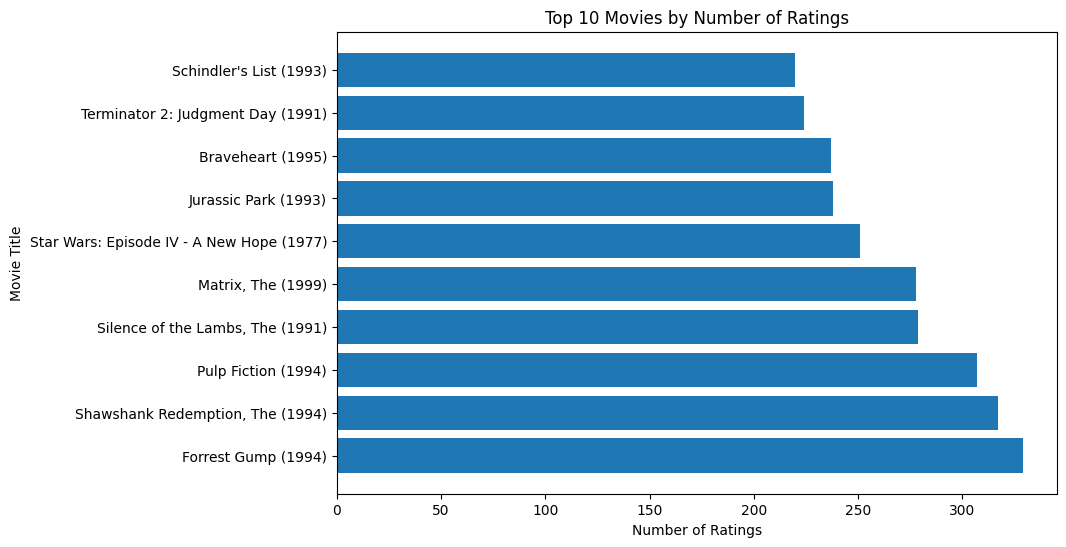

In [15]:
top_movies = movie_ratings_merged.nlargest(10, 'num_ratings')
plt.figure(figsize=(12,6))
plt.barh(top_movies['title'], top_movies['num_ratings'])
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')
plt.title('Top 10 Movies by Number of Ratings')
plt.subplots_adjust(left=0.3)  # Adjust the left margin
plt.savefig('top10movies.png')
plt.show()

In [16]:
print(f"Mean Rating: {ratings['rating'].mean():.2f}")
print(f"Median Rating: {ratings['rating'].median():.2f}")
print(f"Min Rating: {ratings['rating'].min():.2f}")
print(f"Max Rating: {ratings['rating'].max():.2f}")


Mean Rating: 3.50
Median Rating: 3.50
Min Rating: 0.50
Max Rating: 5.00


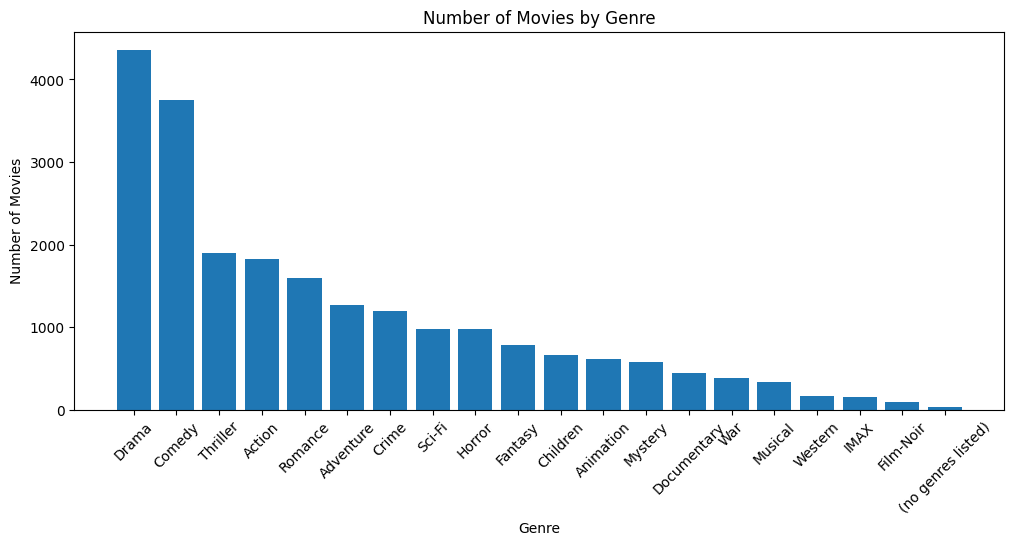

In [17]:
# Genre Analysis
movies_genres = movies.copy()
movies_genres['genres'] = movies['genres'].str.split('|')
movie_genres = movies_genres.explode('genres')
genre_counts = movie_genres['genres'].value_counts()
plt.figure(figsize=(12,6))
plt.bar(genre_counts.index, genre_counts)
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.title('Number of Movies by Genre')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.25)  # Adjust the bottom margin
plt.savefig("numberofmoviesbygenre.png")
plt.show()

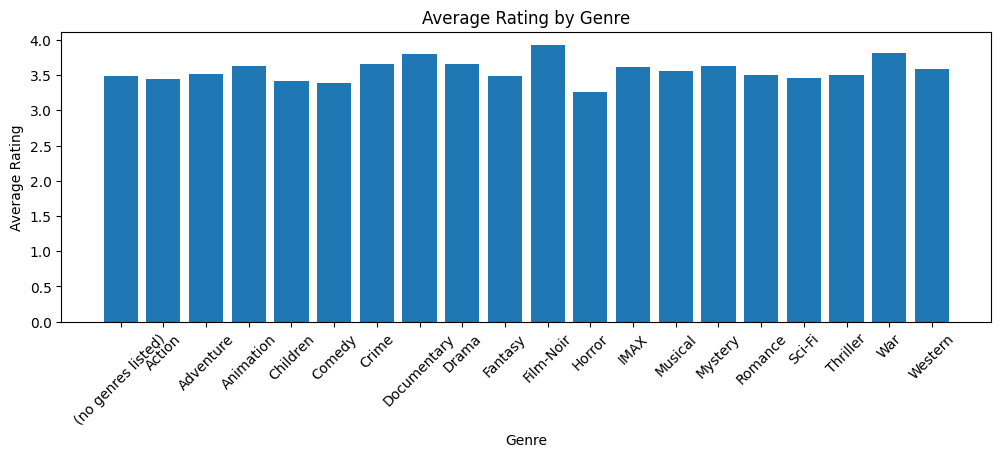

In [18]:
avg_rating_by_genre = pd.merge(movie_genres, ratings, on='movieId')
avg_rating_by_genre = avg_rating_by_genre.groupby('genres')['rating'].mean().reset_index()
plt.figure(figsize=(12, 5))
plt.bar(avg_rating_by_genre['genres'], avg_rating_by_genre['rating'])
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Average Rating by Genre')
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.3)  # Adjust the bottom margin
plt.savefig("ratingbygenre")
plt.show()

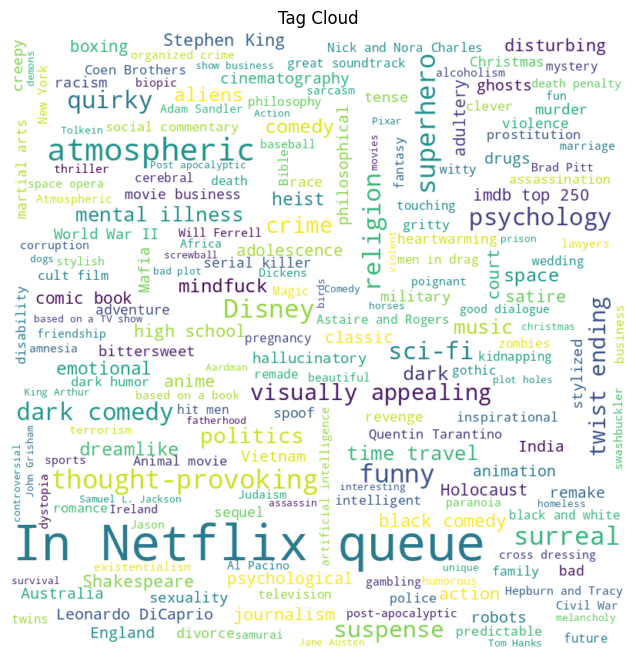

In [19]:
tag_counts = tags['tag'].value_counts()
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(tag_counts)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Tag Cloud')
plt.savefig("tagcloud.png")
plt.show()

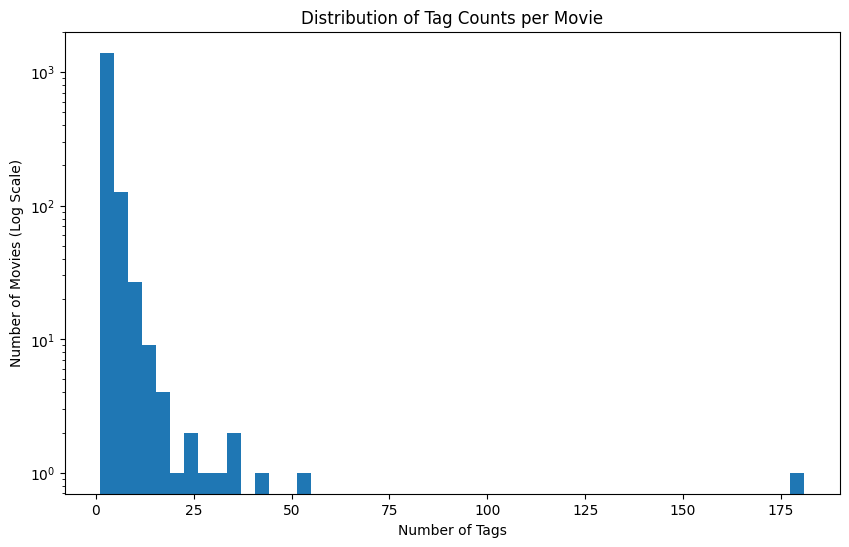

In [20]:
tags_per_movie = tags.groupby('movieId').size().reset_index(name='num_tags')
plt.figure(figsize=(10,6))
plt.hist(tags_per_movie['num_tags'], bins=50, log = True)
plt.xlabel('Number of Tags')
plt.ylabel('Number of Movies (Log Scale)')
plt.title('Distribution of Tag Counts per Movie')
plt.show()

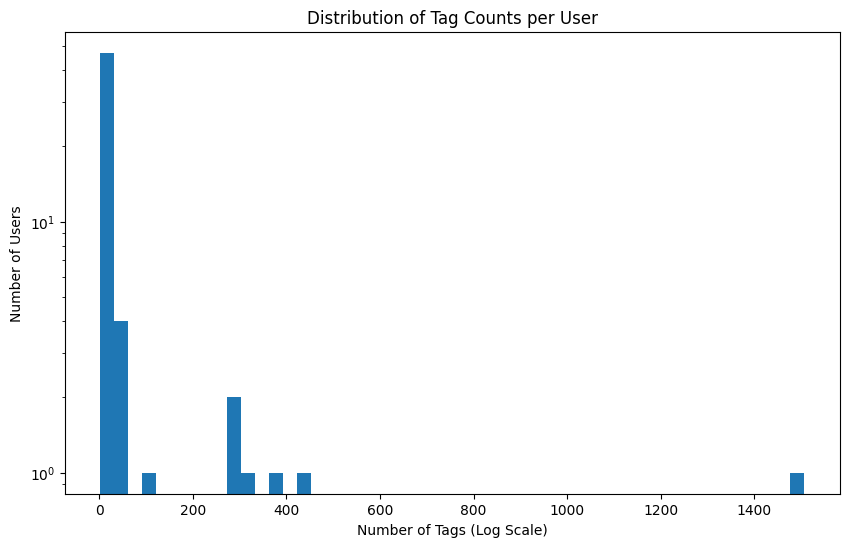

In [21]:
tags_per_user = tags.groupby('userId').size().reset_index(name='num_tags')
plt.figure(figsize=(10,6))
plt.hist(tags_per_user['num_tags'], bins=50, log = True)
plt.xlabel('Number of Tags (Log Scale)')
plt.ylabel('Number of Users')
plt.title('Distribution of Tag Counts per User')
plt.savefig("tagcountsperuser")
plt.show()

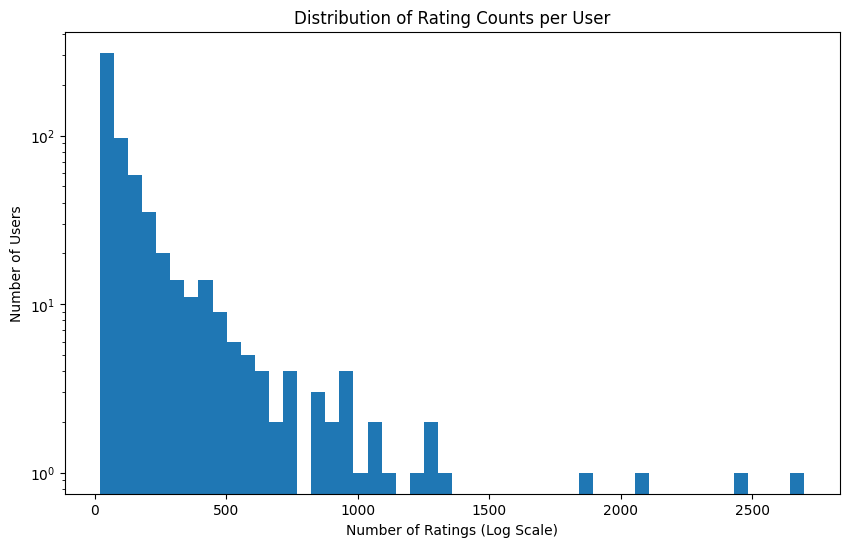

In [22]:
ratings_per_user = ratings.groupby('userId').size().reset_index(name='num_ratings')
plt.figure(figsize=(10,6))
plt.hist(ratings_per_user['num_ratings'], bins=50, log = True)
plt.xlabel('Number of Ratings (Log Scale)')
plt.ylabel('Number of Users')
plt.title('Distribution of Rating Counts per User')
plt.savefig("ratingcountsperuser")
plt.show()

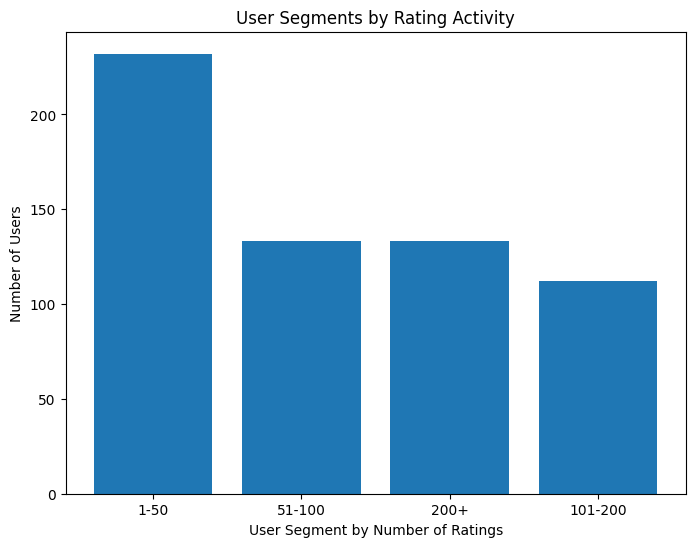

In [23]:
ratings_per_user['user_segment'] = pd.cut(ratings_per_user['num_ratings'], bins=[0, 50, 100, 200, float('inf')], labels=['1-50', '51-100', '101-200', '200+'])
user_segment_counts = ratings_per_user['user_segment'].value_counts()
plt.figure(figsize=(8,6))
plt.bar(user_segment_counts.index, user_segment_counts)
plt.xlabel('User Segment by Number of Ratings')
plt.ylabel('Number of Users')
plt.title('User Segments by Rating Activity')
plt.savefig("usersegmentsbynumberofratings.png")
plt.show()

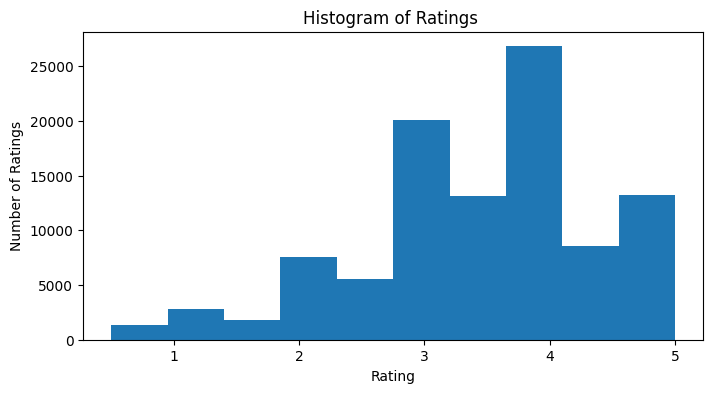

In [24]:
plt.figure(figsize=(8,4))
plt.hist(ratings['rating'])

# Set plot title and labels
plt.title('Histogram of Ratings ')
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')

# Show the plot
plt.savefig("histogramofratings")
plt.show()


# SGD Factorisation

In [25]:
ratings_df = pd.merge(ratings, movies)[['userId', 'title', 'rating', 'timestamp']]

In [26]:
ratings_df.head(1)

,userId,title,rating,timestamp
0,1,Toy Story (1995),4.0,964982703


In [27]:
ratings_df["userId"] = ratings_df["userId"].astype(str)

In [28]:
ratings_df.head(3)

,userId,title,rating,timestamp
0,1,Toy Story (1995),4.0,964982703
1,1,Grumpier Old Men (1995),4.0,964981247
2,1,Heat (1995),4.0,964982224


In [29]:
ratings_df.dtypes

userId        object
title         object
rating       float64
timestamp      int64
dtype: object

In [30]:
ratings_df

,userId,title,rating,timestamp
0,1,Toy Story (1995),4.0,964982703
1,1,Grumpier Old Men (1995),4.0,964981247
2,1,Heat (1995),4.0,964982224
3,1,Seven (a.k.a. Se7en) (1995),5.0,964983815
4,1,"Usual Suspects, The (1995)",5.0,964982931
...,...,...,...,...
100831,610,Split (2017),4.0,1493848402
100832,610,John Wick: Chapter Two (2017),5.0,1493850091
100833,610,Get Out (2017),5.0,1494273047
100834,610,Logan (2017),5.0,1493846352


In [31]:
ratings_per_user = ratings_df.groupby('userId').rating.count()
ratings_per_item = ratings_df.groupby('title').rating.count()

print(f"Total No. of users: {len(ratings_df.userId.unique())}")
print(f"Total No. of items: {len(ratings_df.title.unique())}")
print("\n")

print(f"Max observed rating: {ratings_df.rating.max()}")
print(f"Min observed rating: {ratings_df.rating.min()}")
print("\n")

print(f"Max no. of user ratings: {ratings_per_user.max()}")
print(f"Min no. of user ratings: {ratings_per_user.min()}")
print(f"Median no. of ratings per user: {ratings_per_user.median()}")
print("\n")

print(f"Max no. of item ratings: {ratings_per_item.max()}")
print(f"Min no. of item ratings: {ratings_per_item.min()}")
print(f"Median no. of ratings per item: {ratings_per_item.median()}")


Total No. of users: 610
Total No. of items: 9719


Max observed rating: 5.0
Min observed rating: 0.5


Max no. of user ratings: 2698
Min no. of user ratings: 20
Median no. of ratings per user: 70.5


Max no. of item ratings: 329
Min no. of item ratings: 1
Median no. of ratings per item: 3.0


### Splitting into training and validation sets

In [32]:
def get_last_n_ratings_by_user(
    df, n, min_ratings_per_user=1, user_colname="userId", timestamp_colname="timestamp"
):
    return (
        df.groupby(user_colname)
        .filter(lambda x: len(x) >= min_ratings_per_user)
        .sort_values(timestamp_colname)
        .groupby(user_colname)
        .tail(n)
        .sort_values(user_colname)
    )

In [33]:
get_last_n_ratings_by_user(ratings_df, 1)

,userId,title,rating,timestamp
161,1,20 Dates (1998),4.0,965719662
1125,10,Dirty Dancing (1987),3.0,1455619275
15410,100,"Blair Witch Project, The (1999)",2.0,1100277691
15456,101,"Sweet Hereafter, The (1997)",5.0,968443804
15564,102,Phenomenon (1996),3.0,840635071
...,...,...,...,...
15035,95,WarGames (1983),4.0,1105401227
15046,96,Showgirls (1995),1.0,964774290
15119,97,Speed (1994),4.0,1047481515
15240,98,10 Cloverfield Lane (2016),4.5,1532458398


In [34]:
def mark_last_n_ratings_as_validation_set(
    df, n, min_ratings=1, user_colname="userId", timestamp_colname="timestamp"
):
    """
    Mark the chronologically last n ratings as the validation set.
    This is done by adding the additional 'is_valid' column to the df.
    :param df: a DataFrame containing user item ratings
    :param n: the number of ratings to include in the validation set
    :param min_ratings: only include users with more than this many ratings
    :param userId_colname: the name of the column containing user ids
    :param timestamp_colname: the name of the column containing the imestamps
    :return: the same df with the additional 'is_valid' column added
    """
    df["is_valid"] = False
    df.loc[
        get_last_n_ratings_by_user(
            df,
            n,
            min_ratings,
            user_colname=user_colname,
            timestamp_colname=timestamp_colname,
        ).index,
        "is_valid",
    ] = True

    return df

Last two ratings by a user

In [35]:
mark_last_n_ratings_as_validation_set(ratings_df, 2)

,userId,title,rating,timestamp,is_valid
0,1,Toy Story (1995),4.0,964982703,False
1,1,Grumpier Old Men (1995),4.0,964981247,False
2,1,Heat (1995),4.0,964982224,False
3,1,Seven (a.k.a. Se7en) (1995),5.0,964983815,False
4,1,"Usual Suspects, The (1995)",5.0,964982931,False
...,...,...,...,...,...
100831,610,Split (2017),4.0,1493848402,False
100832,610,John Wick: Chapter Two (2017),5.0,1493850091,False
100833,610,Get Out (2017),5.0,1494273047,False
100834,610,Logan (2017),5.0,1493846352,False


In [36]:
train_df = ratings_df[ratings_df.is_valid==False]
valid_df = ratings_df[ratings_df.is_valid==True]

In [37]:
len(valid_df)

1220

In [38]:
len(train_df)

99616

## Creating a Baseline Model

Check accuracy with median score dumb model


In [39]:
median_rating = train_df.rating.median(); median_rating
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

predictions = np.array([median_rating]* len(valid_df))

mae = mean_absolute_error(valid_df.rating, predictions)
mse = mean_squared_error(valid_df.rating, predictions)
rmse = math.sqrt(mse)


In [40]:

print(f'mae: {mae:.3f}:')
print(f'mse: {mse:.3f}')
print(f'rmse: {rmse:.3f}')

mae: 0.897:
mse: 1.197
rmse: 1.094


In [41]:
print(median_rating)

3.5


## Matrix factorization with bias

In [42]:
ratings_df[((ratings_df.userId == '1') | 
            (ratings_df.userId == '2')| 
            (ratings_df.userId == '4')) 
           & ((ratings_df.title == "One Flew Over the Cuckoo's Nest (1975)") | 
              (ratings_df.title == "To Kill a Mockingbird (1962)")| 
              (ratings_df.title == "Saving Private Ryan (1998)"))].pivot_table('rating', index='userId', columns='title').fillna('?')

title,Saving Private Ryan (1998)
userId,
1,4.0


In [43]:
user_lookup = {v: i+1 for i, v in enumerate(ratings_df['userId'].unique())}
movie_lookup = {v: i+1 for i, v in enumerate(ratings_df['title'].unique())}

In [44]:
list(movie_lookup.keys())[:5]

['Toy Story (1995)',
 'Grumpier Old Men (1995)',
 'Heat (1995)',
 'Seven (a.k.a. Se7en) (1995)',
 'Usual Suspects, The (1995)']

In [45]:
movie_lookup.get("Bug's Life, A (1998)")

1601

In [46]:
print(user_lookup.get("1"))

1


In [47]:

class UserItemRatingDataset(Dataset):
    def __init__(self, df, movie_lookup, user_lookup):
        self.df = df
        self.movie_lookup = movie_lookup
        self.user_lookup = user_lookup

    def __getitem__(self, index):
        row = self.df.iloc[index]
        userId = self.user_lookup[row.userId]
        movie_id = self.movie_lookup[row.title]
        
        rating = torch.tensor(row.rating, dtype=torch.float32)
        
        return (userId, movie_id), rating

    def __len__(self):
        return len(self.df)

In [48]:
train_dataset = UserItemRatingDataset(train_df, movie_lookup, user_lookup)
valid_dataset = UserItemRatingDataset(valid_df, movie_lookup, user_lookup)

In [49]:
len(train_dataset)

99616

In [55]:
len(valid_dataset)

1220

In [50]:
train_dataset[0]

((1, 1), tensor(4.))

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [52]:
class MfDotBias(nn.Module):

    def __init__(
        self, n_factors, n_users, n_items, ratings_range=None, use_biases=True
    ):
        super().__init__()
        self.bias = use_biases
        self.y_range = ratings_range
        self.user_embedding = nn.Embedding(n_users+1, n_factors, padding_idx=0)
        self.item_embedding = nn.Embedding(n_items+1, n_factors, padding_idx=0)

        if use_biases:
            self.user_bias = nn.Embedding(n_users+1, 1, padding_idx=0)
            self.item_bias = nn.Embedding(n_items+1, 1, padding_idx=0)

    def forward(self, inputs):
        users, items = inputs
        dot = self.user_embedding(users) * self.item_embedding(items)
        result = dot.sum(1)
        if self.bias:
            result = (
                result + self.user_bias(users).squeeze() + self.item_bias(items).squeeze()
            )

        if self.y_range is None:
            return result
        else:
            return (
                torch.sigmoid(result) * (self.y_range[1] - self.y_range[0]) + self.y_range[0]
            )
        


In [53]:
wandb.init(project='movie-recommender', entity='your-entity', config={
'num_epochs': num_epochs,
'batch_size': batch_size,
'learning_rate': learning_rate
})

NameError: name 'num_epochs' is not defined

$$ out_i = \frac{1}{1 + e^{-input_i}} $$
Sigmoid funtion

### Train

In [ ]:
def train_mf_model(num_epochs=50, batch_size=4096, learning_rate=0.1, use_biases=False):
    model = MfDotBias(
        120, len(user_lookup), len(movie_lookup), ratings_range=[0.5, 5.5], use_biases=use_biases
    ).to(device)
    loss_func = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    train_losses = []
    valid_losses = []
    valid_maes = []
    valid_mses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            inputs, targets = batch
            inputs = (inputs[0].to(device), inputs[1].to(device))
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        train_losses.append(total_loss / len(train_loader))
 
        model.eval()
        valid_loss = 0
        valid_mae = 0
        valid_mse = 0
        with torch.no_grad():
            for batch in valid_loader:
                inputs, targets = batch
                inputs = (inputs[0].to(device), inputs[1].to(device))
                targets = targets.to(device)
                outputs = model(inputs)
                valid_loss += loss_func(outputs, targets).item()
                valid_mae += mean_absolute_error(targets.cpu().numpy(), outputs.cpu().numpy())
                valid_mse += mean_squared_error(targets.cpu().numpy(), outputs.cpu().numpy())
        valid_loss /= len(valid_loader)
        valid_mae /= len(valid_loader)
        valid_mse /= len(valid_loader)
        valid_losses.append(valid_loss)
        valid_maes.append(valid_mae)
        valid_mses.append(valid_mse)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.3f}, Valid Loss: {valid_loss:.3f}, Valid MAE: {valid_mae:.3f}, Valid MSE: {valid_mse:.3f}")

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot validation metrics
    plt.figure(figsize=(10, 5))
    plt.plot(valid_maes, label='Validation MAE')
    plt.plot(valid_mses, label='Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('Metric')
    plt.legend()
    plt.show()

    return model


/home/z/projects/st312haowan/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50 - Train Loss: 6.470, Valid Loss: 6.666, Valid MAE: 2.242, Valid MSE: 6.666
Epoch 2/50 - Train Loss: 5.722, Valid Loss: 6.202, Valid MAE: 2.149, Valid MSE: 6.202
Epoch 3/50 - Train Loss: 5.119, Valid Loss: 5.866, Valid MAE: 2.078, Valid MSE: 5.866
Epoch 4/50 - Train Loss: 4.623, Valid Loss: 5.535, Valid MAE: 2.015, Valid MSE: 5.535
Epoch 5/50 - Train Loss: 4.217, Valid Loss: 5.097, Valid MAE: 1.920, Valid MSE: 5.097
Epoch 6/50 - Train Loss: 3.887, Valid Loss: 4.885, Valid MAE: 1.872, Valid MSE: 4.885
Epoch 7/50 - Train Loss: 3.575, Valid Loss: 4.689, Valid MAE: 1.830, Valid MSE: 4.689
Epoch 8/50 - Train Loss: 3.356, Valid Loss: 4.629, Valid MAE: 1.822, Valid MSE: 4.629
Epoch 9/50 - Train Loss: 3.173, Valid Loss: 4.351, Valid MAE: 1.762, Valid MSE: 4.351
Epoch 10/50 - Train Loss: 2.969, Valid Loss: 4.212, Valid MAE: 1.729, Valid MSE: 4.212
Epoch 11/50 - Train Loss: 2.793, Valid Loss: 4.097, Valid MAE: 1.691, Valid MSE: 4.097
Epoch 12/50 - Train Loss: 2.595, Valid Loss: 3.918, 

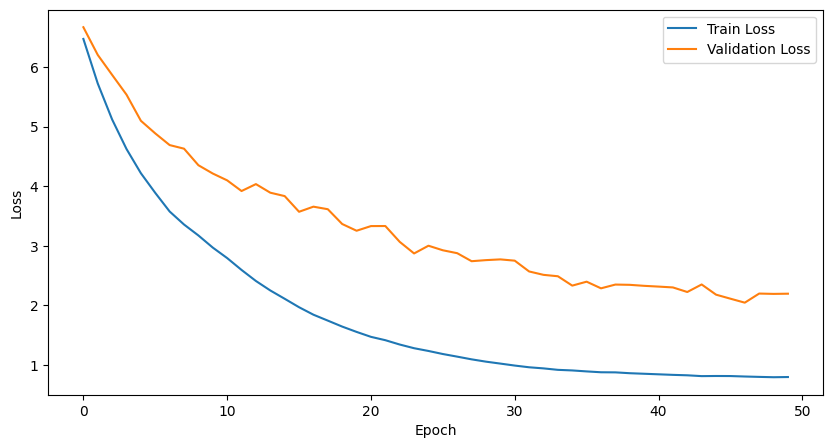

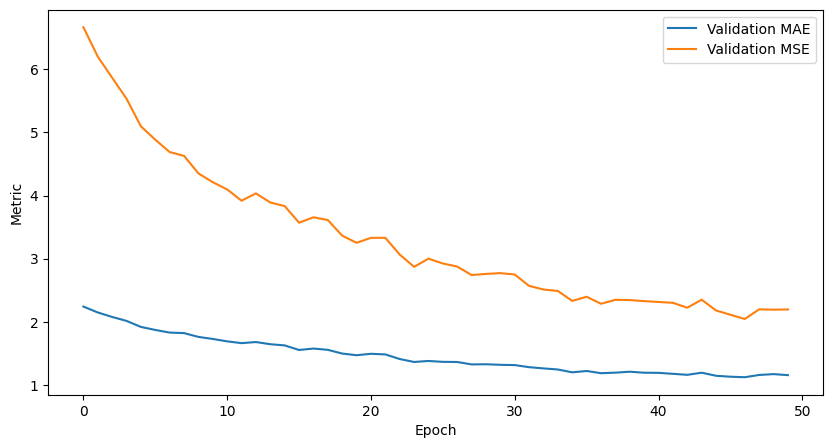

In [ ]:
# Train the matrix factorization model
mf_model_with_bias = train_mf_model(num_epochs=50, batch_size=512, learning_rate=0.02, use_biases=True)

Matrix Factorisation without bias

/home/z/projects/st312haowan/.venv/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/50 - Train Loss: 6.625, Valid Loss: 6.991, Valid MAE: 2.318, Valid MSE: 6.991
Epoch 2/50 - Train Loss: 6.012, Valid Loss: 6.622, Valid MAE: 2.245, Valid MSE: 6.622
Epoch 3/50 - Train Loss: 5.506, Valid Loss: 6.412, Valid MAE: 2.200, Valid MSE: 6.412
Epoch 4/50 - Train Loss: 4.996, Valid Loss: 5.950, Valid MAE: 2.096, Valid MSE: 5.950
Epoch 5/50 - Train Loss: 4.542, Valid Loss: 5.488, Valid MAE: 1.993, Valid MSE: 5.488
Epoch 6/50 - Train Loss: 4.177, Valid Loss: 5.084, Valid MAE: 1.910, Valid MSE: 5.084
Epoch 7/50 - Train Loss: 3.793, Valid Loss: 4.837, Valid MAE: 1.860, Valid MSE: 4.837
Epoch 8/50 - Train Loss: 3.469, Valid Loss: 4.711, Valid MAE: 1.833, Valid MSE: 4.711
Epoch 9/50 - Train Loss: 3.240, Valid Loss: 4.514, Valid MAE: 1.789, Valid MSE: 4.514
Epoch 10/50 - Train Loss: 3.048, Valid Loss: 4.475, Valid MAE: 1.790, Valid MSE: 4.475
Epoch 11/50 - Train Loss: 2.879, Valid Loss: 4.365, Valid MAE: 1.753, Valid MSE: 4.365
Epoch 12/50 - Train Loss: 2.678, Valid Loss: 4.304, 

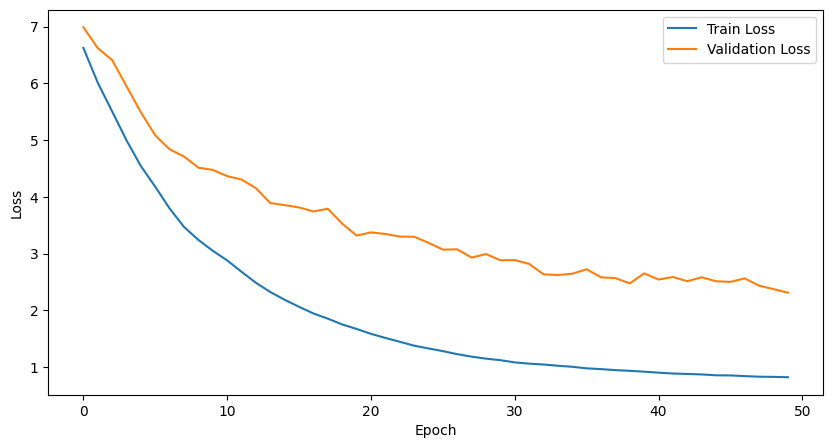

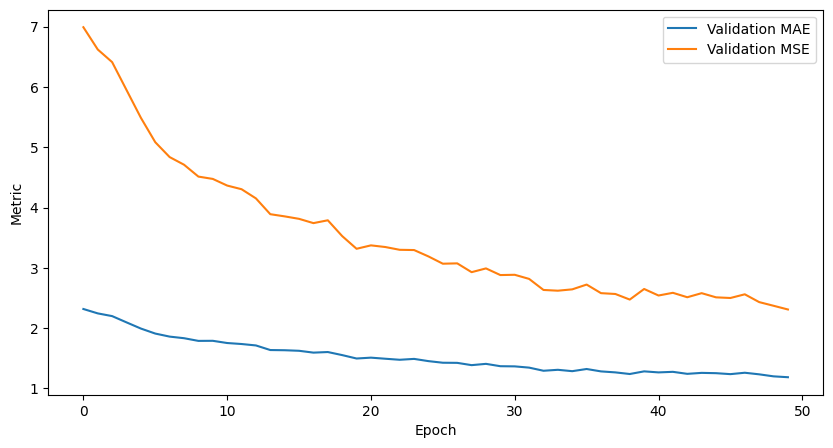

In [ ]:
mf_model_without_bias = train_mf_model(num_epochs=50, batch_size=512, learning_rate=0.02, use_biases=False)

# Transformers
Candidate Number: 24588

Reference: https://medium.com/data-science-at-microsoft/comparing-matrix-factorization-with-transformers-for-movielens-recommendations-using-8e3cd3ec8bd8 Chris Hughes

In [ ]:
import torchmetrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import seaborn as sns
from IPython.display import Image, display
from statsmodels.distributions.empirical_distribution import ECDF

In [ ]:
from pathlib import Path

In [ ]:
dataset_path = Path('ml-latest-small')

tags = pd.read_csv(
    dataset_path/"tags.csv",
    sep=",",
)
ratings = pd.read_csv(
    dataset_path/"ratings.csv",
    sep=",",
)

movies = pd.read_csv(
    dataset_path/"movies.csv",
    sep=","
)
links = pd.read_csv(
    dataset_path/"links.csv",
    sep=","
)

In [ ]:
ratings_df = pd.merge(ratings, movies)[['userId', 'title', 'rating', 'timestamp']]

In [ ]:
ratings_df.head(1)

,userId,title,rating,timestamp
0,1,Toy Story (1995),4.0,964982703


In [ ]:
ratings_df["userId"] = ratings_df["userId"].astype(str)

In [ ]:
ratings_df.head(3)

,userId,title,rating,timestamp
0,1,Toy Story (1995),4.0,964982703
1,5,Toy Story (1995),4.0,847434962
2,7,Toy Story (1995),4.5,1106635946


In [ ]:
ratings_df.dtypes

userId        object
title         object
rating       float64
timestamp      int64
dtype: object

In [ ]:
ratings_per_user = ratings_df.groupby('userId').rating.count()
ratings_per_item = ratings_df.groupby('title').rating.count()

print(f"Total No. of users: {len(ratings_df.userId.unique())}")
print(f"Total No. of items: {len(ratings_df.title.unique())}")
print("\n")

print(f"Max observed rating: {ratings_df.rating.max()}")
print(f"Min observed rating: {ratings_df.rating.min()}")
print("\n")

print(f"Max no. of user ratings: {ratings_per_user.max()}")
print(f"Min no. of user ratings: {ratings_per_user.min()}")
print(f"Median no. of ratings per user: {ratings_per_user.median()}")
print("\n")

print(f"Max no. of item ratings: {ratings_per_item.max()}")
print(f"Min no. of item ratings: {ratings_per_item.min()}")
print(f"Median no. of ratings per item: {ratings_per_item.median()}")


Total No. of users: 610
Total No. of items: 9719


Max observed rating: 5.0
Min observed rating: 0.5


Max no. of user ratings: 2698
Min no. of user ratings: 20
Median no. of ratings per user: 70.5


Max no. of item ratings: 329
Min no. of item ratings: 1
Median no. of ratings per item: 3.0


### Splitting into training and validation sets

In [ ]:
def get_last_n_ratings_by_user(
    df, n, min_ratings_per_user=1, user_colname="userId", timestamp_colname="timestamp"
):
    return (
        df.groupby(user_colname)
        .filter(lambda x: len(x) >= min_ratings_per_user)
        .sort_values(timestamp_colname)
        .groupby(user_colname)
        .tail(n)
        .sort_values(user_colname)
    )

In [ ]:
get_last_n_ratings_by_user(ratings_df, 1)

,userId,title,rating,timestamp
12394,1,20 Dates (1998),4.0,965719662
40627,10,Dirty Dancing (1987),3.0,1455619275
62426,100,"Blair Witch Project, The (1999)",2.0,1100277691
21975,101,"Sweet Hereafter, The (1997)",5.0,968443804
33395,102,Phenomenon (1996),3.0,840635071
...,...,...,...,...
82814,95,WarGames (1983),4.0,1105401227
45212,96,Showgirls (1995),1.0,964774290
31504,97,Speed (1994),4.0,1047481515
48340,98,10 Cloverfield Lane (2016),4.5,1532458398


In [ ]:
def mark_last_n_ratings_as_validation_set(
    df, n, min_ratings=1, user_colname="userId", timestamp_colname="timestamp"
):
    """
    Mark the chronologically last n ratings as the validation set.
    This is done by adding the additional 'is_valid' column to the df.
    :param df: a DataFrame containing user item ratings
    :param n: the number of ratings to include in the validation set
    :param min_ratings: only include users with more than this many ratings
    :param user_id_colname: the name of the column containing user ids
    :param timestamp_colname: the name of the column containing the imestamps
    :return: the same df with the additional 'is_valid' column added
    """
    df["is_valid"] = False
    df.loc[
        get_last_n_ratings_by_user(
            df,
            n,
            min_ratings,
            user_colname=user_colname,
            timestamp_colname=timestamp_colname,
        ).index,
        "is_valid",
    ] = True

    return df

Last two ratings by a user

In [ ]:
mark_last_n_ratings_as_validation_set(ratings_df, 2)

,userId,title,rating,timestamp,is_valid
0,1,Toy Story (1995),4.0,964982703,False
1,5,Toy Story (1995),4.0,847434962,False
2,7,Toy Story (1995),4.5,1106635946,False
3,15,Toy Story (1995),2.5,1510577970,False
4,17,Toy Story (1995),4.5,1305696483,False
...,...,...,...,...,...
100831,610,Bloodmoon (1997),2.5,1479545749,False
100832,610,Sympathy for the Underdog (1971),4.5,1479544998,False
100833,610,Hazard (2005),3.0,1493844794,False
100834,610,Blair Witch (2016),3.5,1493848789,False


In [ ]:
ratings_df.head(3)

,userId,title,rating,timestamp,is_valid
0,1,Toy Story (1995),4.0,964982703,False
1,5,Toy Story (1995),4.0,847434962,False
2,7,Toy Story (1995),4.5,1106635946,False


In [ ]:
train_df = ratings_df[ratings_df.is_valid==False]
valid_df = ratings_df[ratings_df.is_valid==True]

In [ ]:
len(valid_df)

1220

In [ ]:
len(train_df)

99616

## Creating a Baseline Model

Check accuracy with median score dumb model


In [ ]:
median_rating = train_df.rating.median(); median_rating
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

predictions = np.array([median_rating]* len(valid_df))

mae = mean_absolute_error(valid_df.rating, predictions)
mse = mean_squared_error(valid_df.rating, predictions)
rmse = math.sqrt(mse)

print(f'mae: {mae}')
print(f'mse: {mse}')
print(f'rmse: {rmse}')

mae: 0.9127049180327869
mse: 1.241188524590164
rmse: 1.1140864080447996


# Sequential recommendations using a transformer

## Pre-processing the data

In [ ]:
grouped_ratings = ratings_df.sort_values(by='timestamp').groupby('userId').agg(tuple).reset_index()

In [ ]:
grouped_ratings['num_ratings'] = grouped_ratings['rating'].apply(lambda row: len(row))

In [ ]:
grouped_ratings.head()

,userId,title,rating,timestamp,is_valid,num_ratings
0,1,"(She's the One (1996), Star Wars: Episode VI -...","(4.0, 5.0, 4.0, 5.0, 4.0, 5.0, 4.0, 4.0, 5.0, ...","(964980499, 964980499, 964980523, 964980523, 9...","(False, False, False, False, False, False, Fal...",232
1,10,"(Intouchables (2011), Love Actually (2003), Fo...","(5.0, 4.0, 3.5, 3.5, 2.5, 4.0, 4.0, 3.5, 3.5, ...","(1455301553, 1455301621, 1455301685, 145530169...","(False, False, False, False, False, False, Fal...",140
2,100,"(Goodfellas (1990), Legends of the Fall (1994)...","(3.5, 4.0, 3.5, 4.5, 4.5, 1.0, 3.5, 3.5, 4.5, ...","(1100183731, 1100183734, 1100183740, 110018374...","(False, False, False, False, False, False, Fal...",148
3,101,"(Naked Gun 33 1/3: The Final Insult (1994), St...","(2.0, 4.0, 4.0, 1.0, 4.0, 4.0, 4.0, 1.0, 3.0, ...","(968440698, 968440698, 968440698, 968440719, 9...","(False, False, False, False, False, False, Fal...",61
4,102,"(Batman (1989), Dances with Wolves (1990), Apo...","(3.0, 4.0, 3.0, 3.0, 5.0, 4.0, 4.0, 4.0, 3.0, ...","(835875690, 835875690, 835875691, 835875691, 8...","(False, False, False, False, False, False, Fal...",56


In [ ]:
sequence_length = 10

In [ ]:
def create_sequences(values, sequence_length):
    sequences = []
    for i, v in enumerate(values):
        seq = values[:i+1]
        if len(seq) > sequence_length:
            seq = seq[i-sequence_length+1:i+1]
        elif len(seq) < sequence_length:
            seq =(*(['[PAD]'] * (sequence_length - len(seq))), *seq)
       
        sequences.append(seq)
    return sequences

To visualize how this function works, let's apply it, with a sequence length of 3, to the first 10 movies rated by the first user. These movies are:

In [ ]:
grouped_ratings.iloc[0]['title'][:10]

("She's the One (1996)",
 'Star Wars: Episode VI - Return of the Jedi (1983)',
 '13th Warrior, The (1999)',
 'Bambi (1942)',
 'Star Wars: Episode I - The Phantom Menace (1999)',
 'Gladiator (2000)',
 'Road Trip (2000)',
 'Shaft (2000)',
 'Bottle Rocket (1996)',
 'American Beauty (1999)')

Applying our function, we have:

In [ ]:
create_sequences(grouped_ratings.iloc[0]['title'][:10], 3)

[('[PAD]', '[PAD]', "She's the One (1996)"),
 ('[PAD]',
  "She's the One (1996)",
  'Star Wars: Episode VI - Return of the Jedi (1983)'),
 ("She's the One (1996)",
  'Star Wars: Episode VI - Return of the Jedi (1983)',
  '13th Warrior, The (1999)'),
 ('Star Wars: Episode VI - Return of the Jedi (1983)',
  '13th Warrior, The (1999)',
  'Bambi (1942)'),
 ('13th Warrior, The (1999)',
  'Bambi (1942)',
  'Star Wars: Episode I - The Phantom Menace (1999)'),
 ('Bambi (1942)',
  'Star Wars: Episode I - The Phantom Menace (1999)',
  'Gladiator (2000)'),
 ('Star Wars: Episode I - The Phantom Menace (1999)',
  'Gladiator (2000)',
  'Road Trip (2000)'),
 ('Gladiator (2000)', 'Road Trip (2000)', 'Shaft (2000)'),
 ('Road Trip (2000)', 'Shaft (2000)', 'Bottle Rocket (1996)'),
 ('Shaft (2000)', 'Bottle Rocket (1996)', 'American Beauty (1999)')]

In [ ]:
grouped_cols = ['title', 'rating', 'timestamp', 'is_valid'] 
for col in grouped_cols:
    grouped_ratings[col] = grouped_ratings[col].apply(lambda x: create_sequences(x, sequence_length))

In [ ]:
grouped_ratings.head(2)

,userId,title,rating,timestamp,is_valid,num_ratings
0,1,"[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...",232
1,10,"[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...",140


In [ ]:
exploded_ratings = grouped_ratings[['userId', 'title']].explode('title', ignore_index=True)
dfs = [grouped_ratings[[col]].explode(col, ignore_index=True) for col in grouped_cols[1:]]
seq_df = pd.concat([exploded_ratings, *dfs], axis=1)

In [ ]:
seq_df.head(2)

,userId,title,rating,timestamp,is_valid
0,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA..."
1,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA..."


In [ ]:
def get_last_entry(sequence):
    return sequence[-1]

seq_df['is_valid'] = seq_df['is_valid'].apply(get_last_entry)

In [ ]:
seq_df.head(2)

,userId,title,rating,timestamp,is_valid
0,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False
1,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False


In [ ]:
seq_df['target_rating'] = seq_df['rating'].apply(get_last_entry)
seq_df['previous_ratings'] = seq_df['rating'].apply(lambda seq: seq[:-1])
seq_df.drop(columns=['rating'], inplace=True)

In [ ]:
seq_df['pad_mask'] = seq_df['title'].apply(lambda x: (np.array(x) == '[PAD]'))
seq_df['num_pads'] = seq_df['pad_mask'].apply(sum)
seq_df['pad_mask'] = seq_df['pad_mask'].apply(lambda x: x.tolist()) # in case we serialize later

In [ ]:
seq_df.head(2)

,userId,title,timestamp,is_valid,target_rating,previous_ratings,pad_mask,num_pads
0,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,4.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Tru...",9
1,1,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,5.0,"([PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Tru...",8


In [ ]:
train_seq_df = seq_df[seq_df.is_valid == False]
valid_seq_df = seq_df[seq_df.is_valid == True]

## Training the model

In [ ]:
user_lookup = {v: i+1 for i, v in enumerate(ratings_df['userId'].unique())}


In [ ]:
def create_feature_lookup(df, feature):
    lookup = {v: i+1 for i, v in enumerate(df[feature].unique())}
    lookup['[PAD]'] = 0
    return lookup
movie_lookup = create_feature_lookup(ratings_df, 'title')


In [ ]:
from torch.utils.data import Dataset
class MovieSequenceDataset(Dataset):
    def __init__(self, df, movie_lookup, user_lookup):
        super().__init__()
        self.df = df
        self.movie_lookup = movie_lookup
        self.user_lookup = user_lookup

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data = self.df.iloc[index]
        user_id = self.user_lookup[str(data.userId)]
        movie_ids = torch.tensor([self.movie_lookup[title] for title in data.title])

        previous_ratings = torch.tensor(
            [rating if rating != "[PAD]" else 0 for rating in data.previous_ratings]
        )

        attention_mask = torch.tensor(data.pad_mask)
        target_rating = data.target_rating
        encoded_features = {
            "userId": user_id,
            "movie_ids": movie_ids,
            "ratings": previous_ratings,
        }

        return (encoded_features, attention_mask), torch.tensor(
            target_rating, dtype=torch.float32
        )

In [ ]:
train_dataset = MovieSequenceDataset(train_seq_df, movie_lookup, user_lookup)
valid_dataset = MovieSequenceDataset(valid_seq_df, movie_lookup, user_lookup)

In [ ]:
from functools import partial

import torchmetrics

### Transformer model: userId+movieId

In [ ]:
class BstTransformer_id(nn.Module):
    def __init__(
        self,
        movies_num_unique,
        users_num_unique,
        sequence_length=10,
        embedding_size=120,
        num_transformer_layers=1,
        ratings_range=(0.5, 5.0),
    ):
        super().__init__()
        self.sequence_length = sequence_length
        self.y_range = ratings_range
        self.movies_embeddings = nn.Embedding(
            movies_num_unique + 1, embedding_size, padding_idx=0
        )
        self.user_embeddings = nn.Embedding(users_num_unique + 1, embedding_size)
        self.position_embeddings = nn.Embedding(sequence_length, embedding_size)

        self.encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=12,
                dropout=0.1,
                batch_first=True,
                activation="gelu",
            ),
            num_layers=num_transformer_layers,
        )

        self.linear = nn.Sequential(
            nn.Linear(
                embedding_size + (embedding_size * sequence_length),
                1024,
            ),
            nn.BatchNorm1d(1024),
            nn.Mish(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Mish(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Mish(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        features, mask = inputs

        encoded_user_id = self.user_embeddings(features["userId"])

        user_features = encoded_user_id

        encoded_movies = self.movies_embeddings(features["movie_ids"])

        positions = torch.arange(
            0, self.sequence_length, 1, dtype=int, device=features["movie_ids"].device
        )
        positions = self.position_embeddings(positions)

        transformer_features = encoded_movies + positions

        transformer_output = self.encoder(
            transformer_features, src_key_padding_mask=mask
        )
        transformer_output = torch.flatten(transformer_output, start_dim=1)

        combined_output = torch.cat((transformer_output, user_features), dim=1)

        rating = self.linear(combined_output)
        rating = rating.squeeze()
        if self.y_range is None:
            return rating
        else:
            return rating * (self.y_range[1] - self.y_range[0]) + self.y_range[0]


In [ ]:
from torch.utils.data import DataLoader

In [ ]:

def train_seq_model_metric(movie_lookup, user_lookup, train_dataset, valid_dataset, sequence_length, embedding_size=120, patience=5):
    # Initialize model, loss function, and optimizer
    model = BstTransformer_id(len(movie_lookup), len(user_lookup), sequence_length, embedding_size=embedding_size)
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)
    

    # Prepare data loaders
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=512)

    # Initialize metrics
    mse_metric = MeanSquaredError()
    mae_metric = MeanAbsoluteError()
    performance_metrics_history = {'epoch': [], 'mae': [], 'mse': [], 'rmse': []}
    loss_metrics_history = {'epoch': [], 'train_loss': [], 'valid_loss': []}
    
    best_mse = float('inf')
    epochs_no_improve = 0

    # Training loop
    for epoch in range(15):
        # Training phase
        model.train()
        train_loss_epoch = []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss_epoch.append(loss.item())

        # Calculate average training loss for the epoch
        avg_train_loss = sum(train_loss_epoch) / len(train_loss_epoch)
        
        # Validation phase
        model.eval()
        mse_metric.reset()
        mae_metric.reset()
        valid_loss_sum = 0
        valid_loss_count = 0
        with torch.no_grad():
            for inputs, targets in valid_loader:
                outputs = model(inputs)
                loss = loss_func(outputs, targets)
                mse_metric.update(outputs, targets)
                mae_metric.update(outputs, targets)
                valid_loss_sum += loss.item() * targets.size(0)
                valid_loss_count += targets.size(0)

        mse = mse_metric.compute()
        mae = mae_metric.compute()
        rmse = torch.sqrt(mse)
    
        avg_valid_loss = valid_loss_sum / valid_loss_count
        
        # Update performance metrics history
        performance_metrics_history['epoch'].append(epoch)
        performance_metrics_history['mae'].append(mae.item())
        performance_metrics_history['mse'].append(mse.item())
        performance_metrics_history['rmse'].append(rmse.item())
        
        # Update loss metrics history
        loss_metrics_history['epoch'].append(epoch)
        loss_metrics_history['train_loss'].append(avg_train_loss)
        loss_metrics_history['valid_loss'].append(avg_valid_loss)
        
        # Early stopping check
        if mse.item() < best_mse:
            best_mse = mse.item()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        print(f"Epoch {epoch}: Train Loss: {avg_train_loss}, Valid Loss: {avg_valid_loss}")

    # Append best result to performance metrics
    performance_metrics_history['epoch'].append('Best Result')
    performance_metrics_history['mae'].append('-')
    performance_metrics_history['mse'].append(best_mse)
    performance_metrics_history['rmse'].append('-')

    # No need to append the best result to loss metrics since we're not tracking improvement for train_loss
    
    # Return the metrics history as a DataFrame
    return pd.DataFrame(performance_metrics_history), pd.DataFrame(loss_metrics_history)


In [ ]:
train_seq_model_metric(movie_lookup, user_lookup, train_dataset, valid_dataset, sequence_length)

Epoch 0: Train Loss: 0.9623430108412718, Valid Loss: 1.0253087497148357
Epoch 1: Train Loss: 0.799684624794202, Valid Loss: 0.9929215462481389
Epoch 2: Train Loss: 0.7152684905590155, Valid Loss: 0.9421055907108745
Epoch 3: Train Loss: 0.6404643786259187, Valid Loss: 0.9481614435305361
Epoch 4: Train Loss: 0.575116588977667, Valid Loss: 0.9609321428126976
Epoch 5: Train Loss: 0.5056706556907067, Valid Loss: 0.9639626878206847
Epoch 6: Train Loss: 0.4357469048255529, Valid Loss: 0.9773681011356291
Early stopping triggered after 8 epochs.


(         epoch       mae       mse      rmse
 0            0  0.781894  1.025309  1.012575
 1            1  0.769375  0.992922  0.996454
 2            2  0.746788  0.942106  0.970621
 3            3  0.753257  0.948161  0.973736
 4            4    0.7525  0.960932  0.980271
 5            5  0.754033  0.963963  0.981816
 6            6  0.758223  0.977368  0.988619
 7            7  0.771612  1.042558  1.021057
 8  Best Result         -  0.942106         -,
    epoch  train_loss  valid_loss
 0      0    0.962343    1.025309
 1      1    0.799685    0.992922
 2      2    0.715268    0.942106
 3      3    0.640464    0.948161
 4      4    0.575117    0.960932
 5      5    0.505671    0.963963
 6      6    0.435747    0.977368
 7      7    0.364759    1.042558)

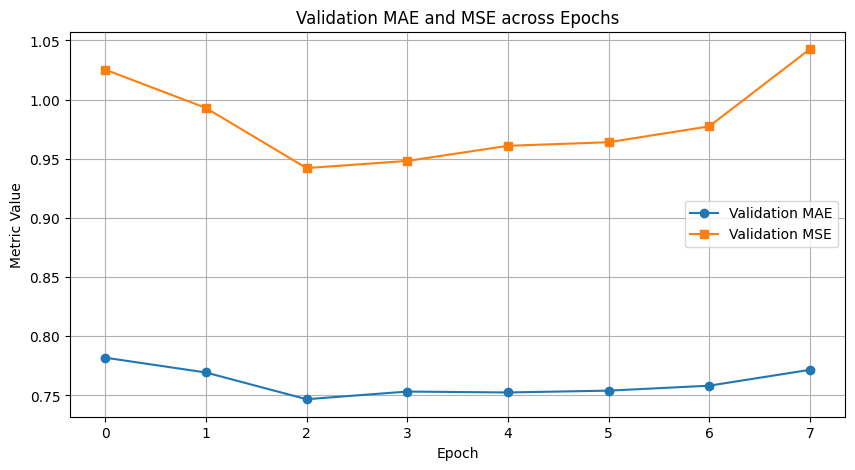

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data extracted from the provided screenshot for epochs, MAE, and MSE.
data = {
    'epoch': [0, 1, 2, 3, 4, 5, 6, 7],
    'mae': [0.781894, 0.769375, 0.746788, 0.753257, 0.7525, 0.754033, 0.758223, 0.771612],
    'mse': [1.025309, 0.992922, 0.942106, 0.948161, 0.960932, 0.963963, 0.977368, 1.042558]
}

df = pd.DataFrame(data)

# Plotting Validation MAE and MSE as line graphs.
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['mae'], label='Validation MAE', marker='o')
plt.plot(df['epoch'], df['mse'], label='Validation MSE', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation MAE and MSE across Epochs')
plt.legend()
plt.grid(True)
plt.show()


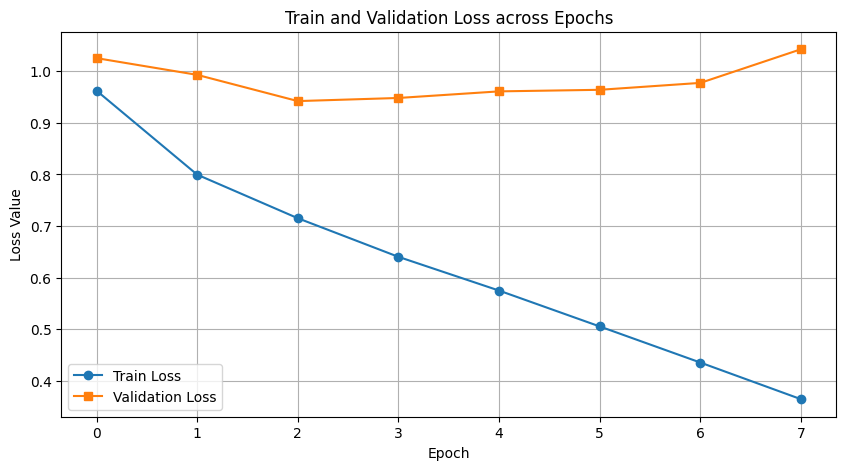

In [ ]:


data = {
    'epoch': [0, 1, 2, 3, 4, 5, 6, 7],
    'train_loss': [0.962343, 0.799685, 0.715268, 0.640464, 0.575117, 0.505671, 0.435747, 0.364759],
    'valid_loss': [1.025309, 0.992922, 0.942106, 0.948161, 0.960932, 0.963963, 0.977368, 1.042558]
}

# Convert the data into a DataFrame.
df = pd.DataFrame(data)

# Plot Train Loss and Validation Loss as line graphs.
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o')
plt.plot(df['epoch'], df['valid_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Train and Validation Loss across Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Adding additional data ： rating

In [ ]:
class BstTransformer_rating(nn.Module):
    def __init__(
        self,
        movies_num_unique,
        users_num_unique,
        sequence_length=10,
        embedding_size=120,
        num_transformer_layers=1,
        ratings_range=(0.5, 5.0),
    ):
        super().__init__()
        self.sequence_length = sequence_length
        self.y_range = ratings_range
        self.movies_embeddings = nn.Embedding(
            movies_num_unique + 1, embedding_size, padding_idx=0
        )
        self.user_embeddings = nn.Embedding(users_num_unique + 1, embedding_size)
        self.ratings_embeddings = nn.Embedding(6, embedding_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(sequence_length, embedding_size)

        self.encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=12,
                dropout=0.1,
                batch_first=True,
                activation="gelu",
            ),
            num_layers=num_transformer_layers,
        )

        self.linear = nn.Sequential(
            nn.Linear(
                embedding_size + (embedding_size * sequence_length),
                1024,
            ),
            nn.BatchNorm1d(1024),
            nn.Mish(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Mish(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Mish(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        features, mask = inputs

        encoded_user_id = self.user_embeddings(features["userId"])

        user_features = encoded_user_id

        movie_history = features["movie_ids"][:, :-1]
        target_movie = features["movie_ids"][:, -1]

        ratings_indices = (features["ratings"] * 2).long()
        ratings_indices = torch.clamp(ratings_indices, 0, 5)
        ratings = self.ratings_embeddings(ratings_indices)

        encoded_movies = self.movies_embeddings(movie_history)
        encoded_target_movie = self.movies_embeddings(target_movie)

        positions = torch.arange(
            0,
            self.sequence_length - 1,
            1,
            dtype=int,
            device=features["movie_ids"].device,
        )
        positions = self.position_embeddings(positions)

        encoded_sequence_movies_with_position_and_rating = (
            encoded_movies + ratings + positions
        )
        encoded_target_movie = encoded_target_movie.unsqueeze(1)

        transformer_features = torch.cat(
            (encoded_sequence_movies_with_position_and_rating, encoded_target_movie),
            dim=1,
        )
        transformer_output = self.encoder(
            transformer_features, src_key_padding_mask=mask
        )
        transformer_output = torch.flatten(transformer_output, start_dim=1)

        combined_output = torch.cat((transformer_output, user_features), dim=1)

        rating = self.linear(combined_output)
        rating = rating.squeeze()
        if self.y_range is None:
            return rating
        else:
            return rating * (self.y_range[1] - self.y_range[0]) + self.y_range[0]


In [ ]:
def train_seq_model_metric(movie_lookup, user_lookup, train_dataset, valid_dataset, sequence_length, embedding_size=120, patience=5):
    # Initialize model, loss function, and optimizer
    model = BstTransformer_rating(len(movie_lookup), len(user_lookup), sequence_length, embedding_size=embedding_size)
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)
    

    # Prepare data loaders
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=512)

    # Initialize metrics
    mse_metric = MeanSquaredError()
    mae_metric = MeanAbsoluteError()
    performance_metrics_history = {'epoch': [], 'mae': [], 'mse': [], 'rmse': []}
    loss_metrics_history = {'epoch': [], 'train_loss': [], 'valid_loss': []}
    
    best_mse = float('inf')
    epochs_no_improve = 0

    # Training loop
    for epoch in range(15):
        # Training phase
        model.train()
        train_loss_epoch = []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss_epoch.append(loss.item())

        # Calculate average training loss for the epoch
        avg_train_loss = sum(train_loss_epoch) / len(train_loss_epoch)
        
        # Validation phase
        model.eval()
        mse_metric.reset()
        mae_metric.reset()
        valid_loss_sum = 0
        valid_loss_count = 0
        with torch.no_grad():
            for inputs, targets in valid_loader:
                outputs = model(inputs)
                loss = loss_func(outputs, targets)
                mse_metric.update(outputs, targets)
                mae_metric.update(outputs, targets)
                valid_loss_sum += loss.item() * targets.size(0)
                valid_loss_count += targets.size(0)

        mse = mse_metric.compute()
        mae = mae_metric.compute()
        rmse = torch.sqrt(mse)
    
        avg_valid_loss = valid_loss_sum / valid_loss_count
        
        # Update performance metrics history
        performance_metrics_history['epoch'].append(epoch)
        performance_metrics_history['mae'].append(mae.item())
        performance_metrics_history['mse'].append(mse.item())
        performance_metrics_history['rmse'].append(rmse.item())
        
        # Update loss metrics history
        loss_metrics_history['epoch'].append(epoch)
        loss_metrics_history['train_loss'].append(avg_train_loss)
        loss_metrics_history['valid_loss'].append(avg_valid_loss)
        
        # Early stopping check
        if mse.item() < best_mse:
            best_mse = mse.item()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        print(f"Epoch {epoch}: Train Loss: {avg_train_loss}, Valid Loss: {avg_valid_loss}")

    # Append best result to performance metrics
    performance_metrics_history['epoch'].append('Best Result')
    performance_metrics_history['mae'].append('-')
    performance_metrics_history['mse'].append(best_mse)
    performance_metrics_history['rmse'].append('-')

    # No need to append the best result to loss metrics since we're not tracking improvement for train_loss
    
    # Return the metrics history as a DataFrame
    return pd.DataFrame(performance_metrics_history), pd.DataFrame(loss_metrics_history)


In [ ]:
train_seq_model_metric(movie_lookup, user_lookup, train_dataset, valid_dataset, sequence_length)

Epoch 0: Train Loss: 0.8939443921431517, Valid Loss: 0.9123891568574749
Epoch 1: Train Loss: 0.7639264815892929, Valid Loss: 0.8962812298634013
Epoch 2: Train Loss: 0.6877861704581824, Valid Loss: 0.8936062212850227
Epoch 3: Train Loss: 0.6222067796266996, Valid Loss: 0.9060950267510336
Epoch 4: Train Loss: 0.5485975922682347, Valid Loss: 0.9928511084103193
Epoch 5: Train Loss: 0.477788126315826, Valid Loss: 1.0053481066813235
Epoch 6: Train Loss: 0.406612760745562, Valid Loss: 0.9702502158821606
Early stopping triggered after 8 epochs.


(         epoch       mae       mse      rmse
 0            0  0.744356  0.912389  0.955191
 1            1  0.729812  0.896281  0.946721
 2            2  0.729484  0.893606  0.945307
 3            3  0.742193  0.906095   0.95189
 4            4  0.756899  0.992851  0.996419
 5            5  0.762858  1.005348  1.002671
 6            6  0.757603  0.970250  0.985013
 7            7  0.762503  1.006150   1.00307
 8  Best Result         -  0.893606         -,
    epoch  train_loss  valid_loss
 0      0    0.893944    0.912389
 1      1    0.763926    0.896281
 2      2    0.687786    0.893606
 3      3    0.622207    0.906095
 4      4    0.548598    0.992851
 5      5    0.477788    1.005348
 6      6    0.406613    0.970250
 7      7    0.346416    1.006150)

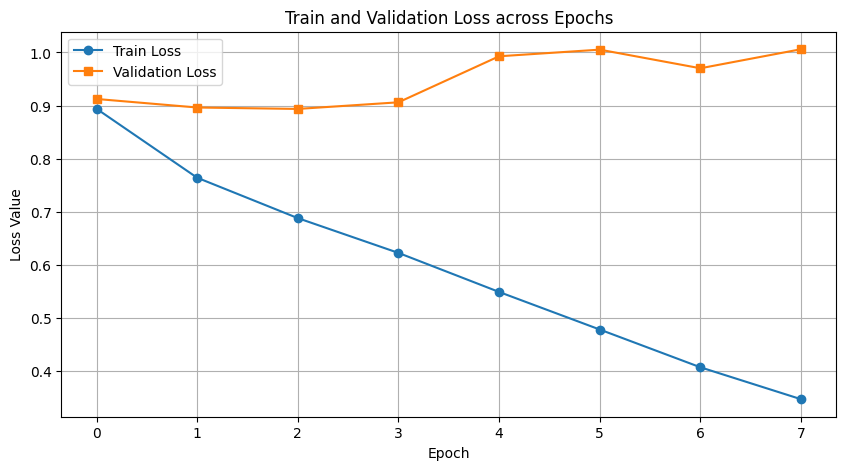

In [ ]:
data = {
    'epoch': [0, 1, 2, 3, 4, 5, 6, 7],
    'train_loss': [0.893944, 0.763926, 0.687786, 0.622207, 0.548598, 0.477788, 0.406613, 0.346416],
    'valid_loss': [0.912389, 0.896281, 0.893606, 0.906095, 0.992851, 1.005348, 0.970250, 1.006150]
}

# Convert the data into a DataFrame.
df = pd.DataFrame(data)

# Plot Train Loss and Validation Loss as line graphs.
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o')
plt.plot(df['epoch'], df['valid_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Train and Validation Loss across Epochs')
plt.legend()
plt.grid(True)
plt.show()


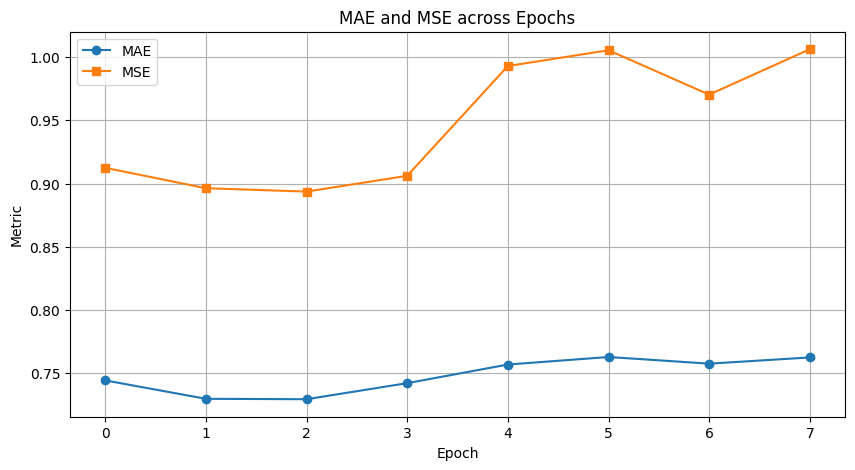

In [ ]:

data = {
    'epoch': [0, 1, 2, 3, 4, 5, 6, 7],
    'mae': [0.744356, 0.729812, 0.729484, 0.742193, 0.756899, 0.762858, 0.757603, 0.762503],
    'mse': [0.912389, 0.896281, 0.893606, 0.906095, 0.992851, 1.005348, 0.970250, 1.006150],
    # 'rmse' is not needed for the graph as we are only plotting mae and mse.
}

# Convert the data into a DataFrame.
df = pd.DataFrame(data)

# Plot MAE and MSE as line graphs.
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['mae'], label='MAE', marker='o')
plt.plot(df['epoch'], df['mse'], label='MSE', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('MAE and MSE across Epochs')
plt.legend()
plt.grid(True)
plt.show()


## Adding feature: genres

In [ ]:
movies['split_genres'] = movies['genres'].str.split('|')

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(movies['split_genres'])

In [ ]:
genres_df = pd.DataFrame(genres_encoded, columns=mlb.classes_)
genres_df

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9738,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9740,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
movies_df = movies.join(genres_df)
movies_df.head()

,movieId,title,genres,split_genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,"[Adventure, Children, Fantasy]",0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,"[Comedy, Romance]",0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"[Comedy, Drama, Romance]",0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,[Comedy],0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ratings_df = pd.merge(ratings, movies)[['userId', 'title', 'rating','timestamp']]

In [ ]:
ratings_df = pd.merge(ratings, movies_df, left_on='movieId', right_on='movieId')

In [ ]:
ratings_df = ratings_df[['userId', 'title', 'rating', 'timestamp'] + list(mlb.classes_)]

In [ ]:
ratings_df.head()

,userId,title,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),4.0,964982703,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5,Toy Story (1995),4.0,847434962,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,7,Toy Story (1995),4.5,1106635946,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,15,Toy Story (1995),2.5,1510577970,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,17,Toy Story (1995),4.5,1305696483,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ratings_df["userId"] = ratings_df["userId"].astype(str)

In [ ]:
get_last_n_ratings_by_user(ratings_df, 1)

,userId,title,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
12394,1,20 Dates (1998),4.0,965719662,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
40627,10,Dirty Dancing (1987),3.0,1455619275,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
62426,100,"Blair Witch Project, The (1999)",2.0,1100277691,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
21975,101,"Sweet Hereafter, The (1997)",5.0,968443804,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33395,102,Phenomenon (1996),3.0,840635071,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82814,95,WarGames (1983),4.0,1105401227,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
45212,96,Showgirls (1995),1.0,964774290,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31504,97,Speed (1994),4.0,1047481515,0,1,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
48340,98,10 Cloverfield Lane (2016),4.5,1532458398,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
mark_last_n_ratings_as_validation_set(ratings_df, 2)

,userId,title,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,is_valid
0,1,Toy Story (1995),4.0,964982703,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,False
1,5,Toy Story (1995),4.0,847434962,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,False
2,7,Toy Story (1995),4.5,1106635946,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,False
3,15,Toy Story (1995),2.5,1510577970,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,False
4,17,Toy Story (1995),4.5,1305696483,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,Bloodmoon (1997),2.5,1479545749,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,False
100832,610,Sympathy for the Underdog (1971),4.5,1479544998,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,False
100833,610,Hazard (2005),3.0,1493844794,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,False
100834,610,Blair Witch (2016),3.5,1493848789,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,False


In [ ]:
ratings_df.head(3)

,userId,title,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,is_valid
0,1,Toy Story (1995),4.0,964982703,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,False
1,5,Toy Story (1995),4.0,847434962,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,False
2,7,Toy Story (1995),4.5,1106635946,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,False


In [ ]:
ratings_df

,userId,title,rating,timestamp,is_valid,genre_combination_index
0,1,Toy Story (1995),4.0,964982703,False,763
1,5,Toy Story (1995),4.0,847434962,False,763
2,7,Toy Story (1995),4.5,1106635946,False,763
3,15,Toy Story (1995),2.5,1510577970,False,763
4,17,Toy Story (1995),4.5,1305696483,False,763
...,...,...,...,...,...,...
100831,610,Bloodmoon (1997),2.5,1479545749,False,457
100832,610,Sympathy for the Underdog (1971),4.5,1479544998,False,386
100833,610,Hazard (2005),3.0,1493844794,False,944
100834,610,Blair Witch (2016),3.5,1493848789,False,874


In [ ]:
train_df = ratings_df[ratings_df.is_valid==False]
valid_df = ratings_df[ratings_df.is_valid==True]

In [ ]:
grouped_ratings = ratings_df.sort_values(by='timestamp').groupby('userId').agg(tuple).reset_index()
grouped_ratings.head(2)

,userId,title,rating,timestamp,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,is_valid
0,1,"(She's the One (1996), Star Wars: Episode VI -...","(4.0, 5.0, 4.0, 5.0, 4.0, 5.0, 4.0, 4.0, 5.0, ...","(964980499, 964980499, 964980523, 964980523, 9...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","(0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, ...",...,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","(0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(False, False, False, False, False, False, Fal..."
1,10,"(Intouchables (2011), Love Actually (2003), Fo...","(5.0, 4.0, 3.5, 3.5, 2.5, 4.0, 4.0, 3.5, 3.5, ...","(1455301553, 1455301621, 1455301685, 145530169...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, ...",...,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(False, False, False, False, False, False, Fal..."
2,100,"(Goodfellas (1990), Legends of the Fall (1994)...","(3.5, 4.0, 3.5, 4.5, 4.5, 1.0, 3.5, 3.5, 4.5, ...","(1100183731, 1100183734, 1100183740, 110018374...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...","(0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","(0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, ...",...,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","(False, False, False, False, False, False, Fal..."
3,101,"(Naked Gun 33 1/3: The Final Insult (1994), St...","(2.0, 4.0, 4.0, 1.0, 4.0, 4.0, 4.0, 1.0, 3.0, ...","(968440698, 968440698, 968440698, 968440719, 9...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...","(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, ...",...,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ..

In [ ]:

# Step 1: Sort by timestamp
ratings_df_sorted = ratings_df.sort_values(by='timestamp')

# Step 2: Group by user and aggregate
grouped_ratings = ratings_df_sorted.groupby('userId').agg({
    'title': lambda x: tuple(x),
    'rating': lambda x: tuple(x),
    'timestamp': lambda x: tuple(x),
    'is_valid': lambda x: tuple(x),
    '(no genres listed)': lambda x: tuple(x),
    'Action': lambda x: tuple(x),
    'Adventure': lambda x: tuple(x),
    'Animation': lambda x: tuple(x),
    'Children': lambda x: tuple(x),
    'Comedy': lambda x: tuple(x),
    'Crime': lambda x: tuple(x),
    'Documentary': lambda x: tuple(x),
    'Drama': lambda x: tuple(x),
    'Fantasy': lambda x: tuple(x),
    'Film-Noir': lambda x: tuple(x),
    'Horror': lambda x: tuple(x),
    'IMAX': lambda x: tuple(x),
    'Musical': lambda x: tuple(x),
    'Mystery': lambda x: tuple(x),
    'Romance': lambda x: tuple(x),
    'Sci-Fi': lambda x: tuple(x),
    'Thriller': lambda x: tuple(x),
    'War': lambda x: tuple(x),
    'Western': lambda x: tuple(x)}).reset_index()


In [ ]:
grouped_ratings.head(2)

,userId,title,rating,timestamp,is_valid,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,"(She's the One (1996), Star Wars: Episode VI -...","(4.0, 5.0, 4.0, 5.0, 4.0, 5.0, 4.0, 4.0, 5.0, ...","(964980499, 964980499, 964980523, 964980523, 9...","(False, False, False, False, False, False, Fal...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...","(0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ...","(0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,10,"(Intouchables (2011), Love Actually (2003), Fo...","(5.0, 4.0, 3.5, 3.5, 2.5, 4.0, 4.0, 3.5, 3.5, ...","(1455301553, 1455301621, 1455301685, 145530169...","(False, False, False, False, False, False, Fal...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,100,"(Goodfellas (1990), Legends of the Fall (1994)...","(3.5, 4.0, 3.5, 4.5, 4.5, 1.0, 3.5, 3.5, 4.5, ...","(1100183731, 1100183734, 1100183740, 110018374...","(False, False, False, False, False, False, Fal...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ...","(0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",...,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,101,"(Naked Gun 33 1/3: The Final Insult (1994), St...","(2.0, 4.0, 4.0, 1.0, 4.0, 4.0, 4.0, 1.0, 3.0, ...","(968440698, 968440698, 968440698, 968440719, 9...","(False, False, False, False, False, False, Fal...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...","(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

The pad_value that you use should match the data type and structure of the values within the column you're padding. When you're working with different types of data (such as titles, ratings, timestamps, or multi-hot encoded genres), each type will require a different pad_value:
For multi-hot encoded genres (binary vectors):
Padding is usually done with a vector of zeros, because multi-hot encoding involves binary vectors where each genre is represented by a 1 for its presence and 0 for its absence. Therefore, a zero-vector of the same length as the genre vectors would be a natural choice for padding.

In [ ]:
sequence_length=10

In [ ]:
def create_sequences(values, sequence_length, pad_value):
    sequences = []
    for i in range(len(values)):
        seq = values[max(0, i - sequence_length + 1):i + 1]
        pad_length = sequence_length - len(seq)
        
        if isinstance(pad_value, list):  # Check if pad_value is a list (used for genres)
            pad = [pad_value] * pad_length  # Create a list of zero-vectors for padding
        else:
            pad = [pad_value] * pad_length  # Create a list of pad_values for padding
        
        # Concatenate pad and seq ensuring both are lists
        seq = pad + seq if isinstance(seq, list) else pad + list(seq)
        sequences.append(seq)
    return sequences


In [ ]:
# use a placeholder string '[PAD]'
grouped_ratings['title'] = grouped_ratings['title'].apply(lambda x: create_sequences(x, sequence_length, '[PAD]'))
grouped_ratings['rating'] = grouped_ratings['rating'].apply(lambda x: create_sequences(x, sequence_length, '[PAD]'))
grouped_ratings['timestamp'] = grouped_ratings['timestamp'].apply(lambda x: create_sequences(x, sequence_length, '[PAD]'))
grouped_ratings['is_valid'] = grouped_ratings['is_valid'].apply(lambda x: create_sequences(x, sequence_length, '[PAD]'))

genre_columns = ['(no genres listed)','Action', 'Adventure', 'Animation', 'Children', 'Comedy','Crime',
                 'Documentary','Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical',
                 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

for i in genre_columns:
    grouped_ratings[i] = grouped_ratings[i].apply(lambda x: create_sequences(x, sequence_length, 0))


In [ ]:
grouped_ratings.head(2)

,userId,title,rating,timestamp,is_valid,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,"[[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...",...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ..."
1,10,"[[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [P...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...",...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, ..."


In [ ]:
grouped_cols = ['title', 'rating', 'timestamp', 'is_valid', '(no genres listed)','Action', 'Adventure', 'Animation', 'Children', 'Comedy','Crime',
                 'Documentary','Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical',
                 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
exploded_ratings = grouped_ratings[['userId', 'title']].explode('title', ignore_index=True)
dfs = [grouped_ratings[[col]].explode(col, ignore_index=True) for col in grouped_cols[1:]]
seq_df = pd.concat([exploded_ratings, *dfs], axis=1)

In [ ]:
seq_df.head(1)

,userId,title,rating,timestamp,is_valid,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,"[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
seq_df['is_valid'] = seq_df['is_valid'].apply(get_last_entry)

False

In [ ]:
seq_df.head(1)

,userId,title,rating,timestamp,is_valid,(no genres listed),Action,Adventure,Animation,Children,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,"[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
seq_df['target_rating'] = seq_df['rating'].apply(get_last_entry)
seq_df['previous_ratings'] = seq_df['rating'].apply(lambda seq: seq[:-1])
seq_df.drop(columns=['rating'], inplace=True)

In [ ]:
seq_df['pad_mask'] = seq_df['title'].apply(lambda x: (np.array(x) == '[PAD]'))
seq_df['num_pads'] = seq_df['pad_mask'].apply(sum)
seq_df['pad_mask'] = seq_df['pad_mask'].apply(lambda x: x.tolist()) # in case we serialize later

In [ ]:
seq_df.head(2)

,userId,title,timestamp,is_valid,(no genres listed),Action,Adventure,Animation,Children,Comedy,...,Mystery,Romance,Sci-Fi,Thriller,War,Western,target_rating,previous_ratings,pad_mask,num_pads
0,1,"[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4.0,"[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Tru...",9
1,1,"[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5.0,"[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Tru...",8
2,1,"[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...",False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4.0,"[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PA...","[True, True, True, True, True, True, True, Fal...",7
3,1,"[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], She...","[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 964...",False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5.0,"[[PAD], [PAD], [PAD], [PAD], [PAD], [PAD], 4.0...","[True, True, True, True, True, True, False, Fa...",6
4,1,"[[PAD], [PAD], [PAD], [PAD], [PAD], She's the ...","[[PAD], [PAD], [PAD], [PAD], [PAD], 964980499,...",False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 1, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 1, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",4.0,"[[PAD], [PAD], [PAD], [PAD], [PAD], 4.0, 5.0, ...","[True, True, True, True, True, False, False, F...",5


In [ ]:
train_seq_df = seq_df[seq_df.is_valid == False]
valid_seq_df = seq_df[seq_df.is_valid == True]

### Train the model: adding genres

In [ ]:
from torch.utils.data import Dataset

In [ ]:
genre_columns = ['(no genres listed)','Action', 'Adventure', 'Animation', 'Children', 'Comedy','Crime',
                 'Documentary','Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical',
                 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

In [ ]:
class MovieSequenceGenreDataset(Dataset):
    def __init__(self, df, movie_lookup, user_lookup, genre_columns):
        super().__init__()
        self.df = df
        self.movie_lookup = movie_lookup
        self.user_lookup = user_lookup
        self.genre_columns = genre_columns

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        data = self.df.iloc[index]
        user_id = self.user_lookup[str(data.userId)]
        movie_ids = torch.tensor([self.movie_lookup[title] for title in data.title])
        
        # Stack all genre columns into a single tensor
        genres = torch.stack([torch.tensor(data[col]) for col in self.genre_columns], dim=1)
        
        previous_ratings = torch.tensor([rating if rating != "[PAD]" else 0 for rating in data.previous_ratings])
        attention_mask = torch.tensor(data.pad_mask, dtype=torch.bool)
        target_rating = torch.tensor(data.target_rating, dtype=torch.float32)

        encoded_features = {
            "userId": user_id,
            "movie_ids": movie_ids,
            "ratings": previous_ratings,
            "genres": genres
        }

        return (encoded_features, attention_mask), target_rating


In [ ]:
train_dataset = MovieSequenceGenreDataset(train_seq_df, movie_lookup, user_lookup,genre_columns)
valid_dataset = MovieSequenceGenreDataset(valid_seq_df, movie_lookup, user_lookup,genre_columns)

In [ ]:
class BstTransformer_genre(nn.Module):
    def __init__(
        self,
        movies_num_unique,
        users_num_unique,
        genres_num_unique,
        sequence_length=10,
        embedding_size=120,
        num_transformer_layers=1,
        ratings_range=(0.5, 5.0),
    ):
        super().__init__()
        self.sequence_length = sequence_length
        self.y_range = ratings_range
        self.movies_embeddings = nn.Embedding(
            movies_num_unique + 1, embedding_size, padding_idx=0
        )
        self.user_embeddings = nn.Embedding(users_num_unique + 1, embedding_size)
        self.ratings_embeddings = nn.Embedding(6, embedding_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(sequence_length, embedding_size)
        
    
        self.genre_embeddings = nn.ModuleList([nn.Embedding(2, embedding_size) for _ in range(genres_num_unique)])

        
        self.encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=embedding_size,
                nhead=12,
                dropout=0.1,
                batch_first=True,
                activation="gelu",
            ),
            num_layers=num_transformer_layers,
        )
        # Final linear layers for prediction
        self.linear = nn.Sequential(
            nn.Linear(
                embedding_size + (embedding_size * sequence_length),
                1024,
            ),
            nn.BatchNorm1d(1024),
            nn.Mish(),
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.Mish(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Mish(),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        features, mask = inputs

        encoded_user_id = self.user_embeddings(features["userId"])

        user_features = encoded_user_id

        movie_history = features["movie_ids"][:, :-1]
        target_movie = features["movie_ids"][:, -1]
        
        ratings_indices = (features["ratings"] * 2).long()
        ratings_indices = torch.clamp(ratings_indices, 0, 5)
        ratings = self.ratings_embeddings(ratings_indices)

        encoded_movies = self.movies_embeddings(movie_history)
        encoded_target_movie = self.movies_embeddings(target_movie)

        positions = torch.arange(
            0,
            self.sequence_length - 1,
            1,
            dtype=int,
            device=features["movie_ids"].device,
        )
        positions = self.position_embeddings(positions)

        encoded_sequence_movies_with_position_and_rating = (
            encoded_movies + ratings + positions
        )
        encoded_target_movie = encoded_target_movie.unsqueeze(1)
        
        genre_embeds = [self.genre_embeddings[i](features['genres'][:, :, i]) for i in range(len(self.genre_embeddings))]
        genre_embeds = torch.stack(genre_embeds, dim=2).sum(dim=2)
        
        
        transformer_features = torch.cat((encoded_sequence_movies_with_position_and_rating, encoded_target_movie), dim=1)
        transformer_features = transformer_features+ genre_embeds
        
        # Pass the features through the transformer
        transformer_output = self.encoder(
            transformer_features, src_key_padding_mask=mask
        )
        transformer_output = torch.flatten(transformer_output, start_dim=1)

        combined_output = torch.cat((transformer_output, user_features), dim=1)
        
        # Make prediction
        rating = self.linear(combined_output)
        rating = rating.squeeze()
        if self.y_range is None:
            return rating
        else:
            return rating * (self.y_range[1] - self.y_range[0]) + self.y_range[0]

In [ ]:

from torch.utils.data import DataLoader
import torch
import pandas as pd
from torchmetrics import MeanSquaredError, MeanAbsoluteError

def train_seq_model_metric(movie_lookup, user_lookup, train_dataset, valid_dataset, sequence_length, embedding_size=120, patience=5):
    # Initialize model, loss function, and optimizer
    model = BstTransformer_genre(len(movie_lookup), len(user_lookup), sequence_length, embedding_size=embedding_size)
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.002)
    

    # Prepare data loaders
    train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=512)

    # Initialize metrics
    mse_metric = MeanSquaredError()
    mae_metric = MeanAbsoluteError()
    performance_metrics_history = {'epoch': [], 'mae': [], 'mse': [], 'rmse': []}
    loss_metrics_history = {'epoch': [], 'train_loss': [], 'valid_loss': []}
    
    best_mse = float('inf')
    epochs_no_improve = 0

    # Training loop
    for epoch in range(15):
        # Training phase
        model.train()
        train_loss_epoch = []
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss_epoch.append(loss.item())

        # Calculate average training loss for the epoch
        avg_train_loss = sum(train_loss_epoch) / len(train_loss_epoch)
        
        # Validation phase
        model.eval()
        mse_metric.reset()
        mae_metric.reset()
        valid_loss_sum = 0
        valid_loss_count = 0
        with torch.no_grad():
            for inputs, targets in valid_loader:
                outputs = model(inputs)
                loss = loss_func(outputs, targets)
                mse_metric.update(outputs, targets)
                mae_metric.update(outputs, targets)
                valid_loss_sum += loss.item() * targets.size(0)
                valid_loss_count += targets.size(0)

        mse = mse_metric.compute()
        mae = mae_metric.compute()
        rmse = torch.sqrt(mse)
    
        avg_valid_loss = valid_loss_sum / valid_loss_count
        
        # Update performance metrics history
        performance_metrics_history['epoch'].append(epoch)
        performance_metrics_history['mae'].append(mae.item())
        performance_metrics_history['mse'].append(mse.item())
        performance_metrics_history['rmse'].append(rmse.item())
        
        # Update loss metrics history
        loss_metrics_history['epoch'].append(epoch)
        loss_metrics_history['train_loss'].append(avg_train_loss)
        loss_metrics_history['valid_loss'].append(avg_valid_loss)
        
        # Early stopping check
        if mse.item() < best_mse:
            best_mse = mse.item()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        print(f"Epoch {epoch}: Train Loss: {avg_train_loss}, Valid Loss: {avg_valid_loss}")

    # Append best result to performance metrics
    performance_metrics_history['epoch'].append('Best Result')
    performance_metrics_history['mae'].append('-')
    performance_metrics_history['mse'].append(best_mse)
    performance_metrics_history['rmse'].append('-')

    # No need to append the best result to loss metrics since we're not tracking improvement for train_loss
    
    # Return the metrics history as a DataFrame
    return pd.DataFrame(performance_metrics_history), pd.DataFrame(loss_metrics_history)


In [ ]:
train_seq_model_metric(movie_lookup, user_lookup, train_dataset, valid_dataset, sequence_length)

Epoch 0: Train Loss: 0.906938529931582, Valid Loss: 0.9278867160687682
Epoch 1: Train Loss: 0.8025511347330534, Valid Loss: 0.9284965356842416
Epoch 2: Train Loss: 0.7528410584498675, Valid Loss: 0.9028910758065396
Epoch 3: Train Loss: 0.7113106614504106, Valid Loss: 0.8877851304460744
Epoch 4: Train Loss: 0.6686419600095505, Valid Loss: 0.8633032273073665
Epoch 5: Train Loss: 0.6325326262376247, Valid Loss: 0.8607406092471763
Epoch 6: Train Loss: 0.601650420213357, Valid Loss: 0.8714022552380797
Epoch 7: Train Loss: 0.572969662073331, Valid Loss: 0.9131659243927628
Epoch 8: Train Loss: 0.5447510746809152, Valid Loss: 0.8759819179284768
Epoch 9: Train Loss: 0.5156621946738317, Valid Loss: 0.924435378098097
Early stopping triggered after 11 epochs.


(          epoch       mae       mse      rmse
 0             0  0.755265  0.927887  0.963269
 1             1  0.750138  0.928497  0.963585
 2             2  0.732957  0.902891  0.950206
 3             3  0.729183  0.887785  0.942223
 4             4  0.712865  0.863303  0.929141
 5             5  0.715051  0.860741  0.927761
 6             6  0.729254  0.871402  0.933489
 7             7  0.730799  0.913166  0.955597
 8             8  0.714754  0.875982  0.935939
 9             9  0.738552  0.924435  0.961476
 10           10  0.719796  0.888485  0.942595
 11  Best Result         -  0.860741         -,
     epoch  train_loss  valid_loss
 0       0    0.906939    0.927887
 1       1    0.802551    0.928497
 2       2    0.752841    0.902891
 3       3    0.711311    0.887785
 4       4    0.668642    0.863303
 5       5    0.632533    0.860741
 6       6    0.601650    0.871402
 7       7    0.572970    0.913166
 8       8    0.544751    0.875982
 9       9    0.515662    0.924435
 10

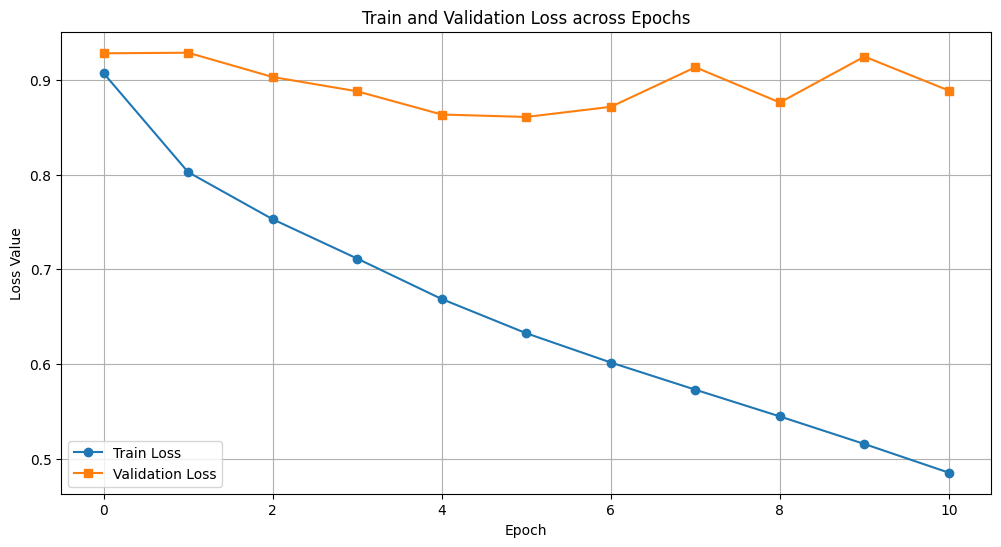

In [ ]:

data = {
    'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'train_loss': [0.906939, 0.802551, 0.752841, 0.711311, 0.668642, 0.632533, 0.601650,
                   0.572970, 0.544751, 0.515662, 0.485377],
    'valid_loss': [0.927887, 0.928497, 0.902891, 0.887785, 0.863303, 0.860741, 0.871402,
                   0.913166, 0.875982, 0.924435, 0.888485]
}

# Convert the data into a DataFrame.
df = pd.DataFrame(data)

# Plot Train Loss and Validation Loss as line graphs.
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['train_loss'], label='Train Loss', marker='o')
plt.plot(df['epoch'], df['valid_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.title('Train and Validation Loss across Epochs')
plt.legend()
plt.grid(True)
plt.show()


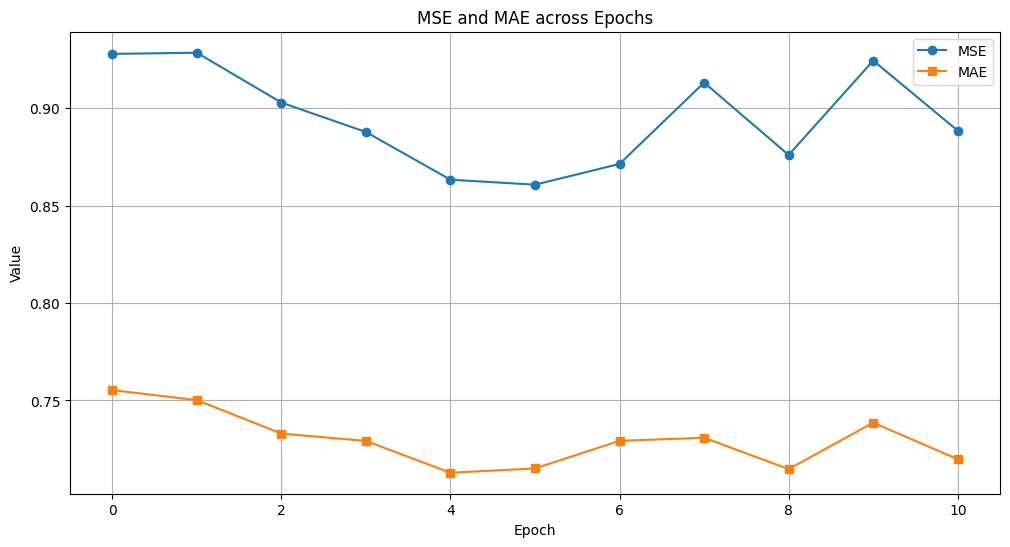

In [ ]:

data = {
    'epoch': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'mse': [0.927887, 0.928497, 0.902891, 0.887785, 0.863303, 0.860741, 0.871402,
            0.913166, 0.875982, 0.924435, 0.888485],
    'mae': [0.755265, 0.750138, 0.732957, 0.729183, 0.712865, 0.715051, 0.729254,
            0.730799, 0.714754, 0.738552, 0.719796]
}

# Convert the data into a DataFrame.
df = pd.DataFrame(data)

# Plot MSE and MAE as line graphs.
plt.figure(figsize=(12, 6))
plt.plot(df['epoch'], df['mse'], label='MSE', marker='o')
plt.plot(df['epoch'], df['mae'], label='MAE', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('MSE and MAE across Epochs')
plt.legend()
plt.grid(True)
plt.show()
